# **Binary Prediction with a Rainfall Dataset**

## **Overview**

Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

## **Problem definition**

### **Goal**

Your goal is to **predict rainfall** for each day of the year.

### **Evaluation**

Submissions are evaluated on [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.

### **Submission File**

For each id in the test set, you must predict a probability for the target rainfall. The file should contain a header and have the following format:
```
id,rainfall
2190,0.5
2191,0.1
2192,0.9
etc.
```

### **Timeline**

- Start Date - March 1, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - March 31, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## **About the Tabular Playground Series**

The goal of the Tabular Playground Series is to provide the Kaggle community with a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The duration of each competition will generally only last a few weeks, and may have longer or shorter durations depending on the challenge. The challenges will generally use fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc.

### **Synthetically-Generated Datasets**

Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

### **Prizes**

- 1st Place - Choice of Kaggle merchandise
- 2nd Place - Choice of Kaggle merchandise
- 3rd Place - Choice of Kaggle merchandise

**Please note**: In order to encourage more participation from beginners, Kaggle merchandise will only be awarded once per person in this series. If a person has previously won, we'll skip to the next team.

### **Citation**

Walter Reade and Elizabeth Park. Binary Prediction with a Rainfall Dataset. https://kaggle.com/competitions/playground-series-s5e3, 2025. Kaggle.

## **Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Rainfall Prediction using Machine Learning](https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning) dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**

- **train.csv** - the training dataset; rainfall is the binary target
- **test.csv** - the test dataset; your objective is to predict the probability of rainfall for each row
- **sample_submission.csv** - a sample submission file in the correct format.


## **Metadata**

#### **Licence**

[MIT](https://www.mit.edu/~amini/LICENSE.md)

# **Problem Solution**

## **Importing necessary libraries**

In [ ]:
# Installing the xgboost library using the 'pip' command.
%pip install xgboost
%pip install xgboost
%pip install pandas
%pip install scikit-learn
%pip install seaborn

In [6]:
# Numpy and pandas
import numpy as np
import pandas as pd

# Fro plotting
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# To split the dataset into train/test and for tuning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold

# Algorithms to use
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Importing the XGBClassifier from the xgboost library
from xgboost import XGBClassifier
from sklearn.base import clone

# Metrics to evaluate the model
#from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score, roc_auc_score

# For Neural networks (copied from another Notebook)
#!export TF_ENABLE_ONEDNN_OPTS=0
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,BatchNormalization, Input, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC
from keras.regularizers import l2
import keras_tuner as kt
from imblearn.over_sampling import SMOTE
from scipy.stats import rankdata


# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

2025-03-28 19:37:10.670556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 19:37:10.699678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Loading the dataset**

In [7]:
# For Colab
#from google.colab import drive
#drive.mount('/content/drive')
#data_directory="/content/drive/MyDrive/Shinhacker/data/"
#results_directory = "/content/drive/MyDrive/Shinhacker/working/"

In [8]:
#path='/kaggle/input/playground-series-s5e2/'
path_input ='./data'
path_output = './working'

In [9]:
# Define constants for attribute names.
columns = (
  'id', 'day', 'pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall'
)
# Upper case constants for variables.
for (v, w) in zip(map(str.upper, columns), columns):
    exec("%s = '%s'" % (v, w))

# Read in the data.
train_df = pd.read_csv(
    '/'.join([path_input,'train.csv']),                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
test_df = pd.read_csv(
    '/'.join([path_input, 'test.csv']),                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns[:-1],                              # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns[:-1],                            # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
train_extra = pd.read_csv(
    '/'.join([path_input, 'Rainfall.csv']),            # Path to input file.
    header = 0,                                        # Header in line 0.
    names = [*columns[1:9],columns[12],*columns[9:-1]],# Column labels defined.
    index_col = False,                                 # No ID column used for index.
    usecols = columns[1:],                             # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    converters = {                                     # Specific transformation for columns:
        RAINFALL: lambda x: 1 if 'yes' else 0,         # Convert "yes"/"no" to 1/0.
        CLOUD: lambda x: np.float64(x),                # Convert to float64.
        HUMIDITY: lambda x: np.float64(x)              # Convert to float64.
    },
    encoding = "ascii",                                # Assume ascii encoding for input data.
)[[*columns[1:]]].rename_axis(ID)

## **Checking the dataset**

In [10]:
train_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            366 non-null    int64  
 1   pressure       366 non-null    float64
 2   maxtemp        366 non-null    float64
 3   temperature    366 non-null    float64
 4   mintemp        366 non-null    float64
 5   dewpoint       366 non-null    float64
 6   humidity       366 non-null    float64
 7   cloud          366 non-null    float64
 8   sunshine       366 non-null    float64
 9   winddirection  365 non-null    float64
 10  windspeed      365 non-null    float64
 11  rainfall       366 non-null    int64  
dtypes: float64(10), int64(2)
memory usage: 34.4 KB


In [11]:
train_extra.head()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1025.900,19.900,18.300,16.800,13.100,72.000,49.000,9.300,80.000,26.300,1
1,2,1022.000,21.700,18.900,17.200,15.600,81.000,83.000,0.600,50.000,15.300,1
2,3,1019.700,20.300,19.300,18.000,18.400,95.000,91.000,0.000,40.000,14.200,1
3,4,1018.900,22.300,20.600,19.100,18.800,90.000,88.000,1.000,50.000,16.900,1
4,5,1015.900,21.300,20.700,20.200,19.900,95.000,81.000,0.000,40.000,13.700,1


In [12]:
train_df.head()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.400,21.200,20.600,19.900,19.400,87.000,88.000,1.100,60.000,17.200,1
1,2,1019.500,16.200,16.900,15.800,15.400,95.000,91.000,0.000,50.000,21.900,1
2,3,1024.100,19.400,16.100,14.600,9.300,75.000,47.000,8.300,70.000,18.100,1
3,4,1013.400,18.100,17.800,16.900,16.800,95.000,95.000,0.000,60.000,35.600,1
4,5,1021.800,21.300,18.400,15.200,9.600,52.000,45.000,3.600,40.000,24.800,0


In [13]:
train_df.shape, test_df.shape

((2190, 12), (730, 11))

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temperature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2190 to 2919
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int64  
 1   pressure       730 non-null    float64
 2   maxtemp        730 non-null    float64
 3   temperature    730 non-null    float64
 4   mintemp        730 non-null    float64
 5   dewpoint       730 non-null    float64
 6   humidity       730 non-null    float64
 7   cloud          730 non-null    float64
 8   sunshine       730 non-null    float64
 9   winddirection  729 non-null    float64
 10  windspeed      730 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 68.4 KB


In [16]:
train_df.nunique(),test_df.nunique()

(day              365
 pressure         236
 maxtemp          219
 temperature      198
 mintemp          199
 dewpoint         218
 humidity          49
 cloud             78
 sunshine         120
 winddirection     35
 windspeed        223
 rainfall           2
 dtype: int64,
 day              365
 pressure         185
 maxtemp          182
 temperature      175
 mintemp          171
 dewpoint         172
 humidity          42
 cloud             69
 sunshine         110
 winddirection     29
 windspeed        205
 dtype: int64)

In [17]:
train_df.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000
mean,179.948,1013.602,26.366,23.953,22.170,20.455,82.037,75.722,3.744,104.863,21.805,0.753
std,105.204,5.655,5.654,5.222,5.059,5.288,7.801,18.026,3.626,80.002,9.899,0.431
min,1.000,999.000,10.400,7.400,4.000,-0.300,39.000,2.000,0.000,10.000,4.400,0.000
25%,89.000,1008.600,21.300,19.300,17.700,16.800,77.000,69.000,0.400,40.000,14.125,1.000
50%,178.500,1013.000,27.800,25.500,23.850,22.150,82.000,83.000,2.400,70.000,20.500,1.000
75%,270.000,1017.775,31.200,28.400,26.400,25.000,88.000,88.000,6.800,200.000,27.900,1.000
max,365.000,1034.600,36.000,31.500,29.800,26.700,98.000,100.000,12.100,300.000,59.500,1.000


In [18]:
test_df.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,729.000,730.000
mean,183.000,1013.503,26.372,23.963,22.110,20.460,82.670,76.360,3.664,103.923,22.484
std,105.438,5.506,5.673,5.278,5.171,5.391,7.819,17.934,3.639,81.695,9.955
min,1.000,1000.000,7.400,5.900,4.200,-0.000,39.000,0.000,0.000,10.000,4.500
25%,92.000,1008.725,21.600,19.825,17.825,16.800,77.250,69.000,0.325,40.000,14.500
50%,183.000,1012.700,27.800,25.650,23.900,22.300,82.000,83.000,2.200,70.000,21.300
75%,274.000,1017.600,31.000,28.375,26.400,25.000,89.000,88.000,6.675,200.000,28.400
max,365.000,1032.200,35.800,31.800,29.100,26.700,98.000,100.000,11.800,300.000,59.500


### **Fix discontinous days**

In [19]:
# Fix discontinous days (use the fact that the indecies go from 0 with increment of 1).
train_df = train_df.assign(**{
    DAY: lambda x: np.array(x.index.to_list())%365+1
})
test_df = test_df.assign(**{
    DAY: lambda x: np.array(x.index.to_list())%365+1
})    

### **Interpolate missing winddirection data point**

In [20]:
# To interpolate between a and b modulus n as (1-t)a+tb
def modnterp(a, b, n, t): # for number in modulus n but perhaps with values outside the rangeþ   
  linterp = lambda p, q, s: (1 - s) * p + s * q
  sgn = lambda z: bool(z > 0) - bool(z < 0)
  def modterp(x, y, m, r):
    if 2*np.abs(x - y) < m: # interpolate if difference is less than half the modulus.
      return linterp(x, y, r)
    elif 2*np.abs(x - y) > m: # shift max(x,y) to 0, interpolate, shift back.
      return (linterp((x + (m - max(x, y))) % m, (y + (m - max(x, y))) % m, r) + max(x, y)) % m
    else: # if the difference between x and y is exactly half the modulus, then select either
          # of the two possible interpolated values (but which one??).
      return (min(x, y) + (m / 4) * np.random.choice([1, -1])) % m
  if (sgn(b - a) == sgn((b % n) - (a % n))):
    return modterp(a % n, b % n, n, t)
  elif ((b % n) > (a % n)): 
    return modterp(a % n, b % -n, n, t) % n
  else:
    return modterp(a % -n, b % n, n, t) % n

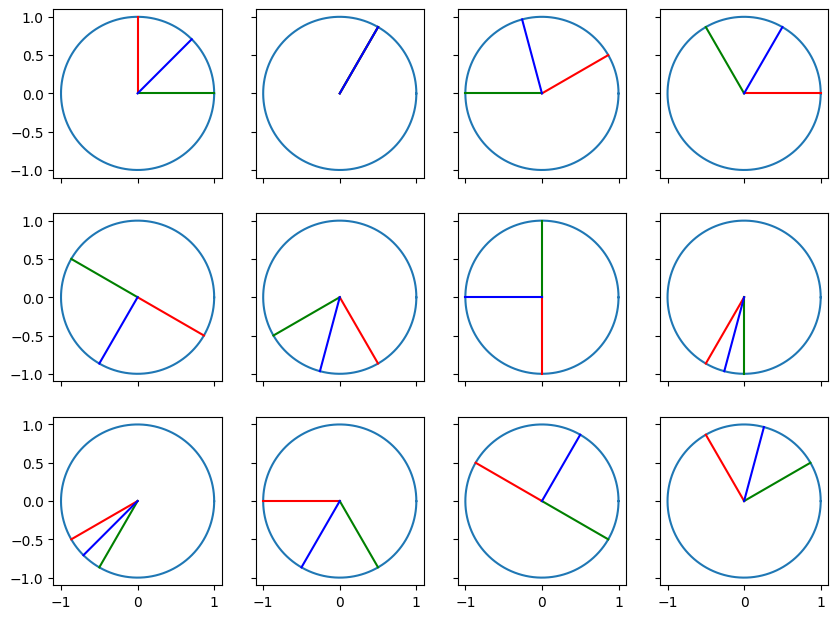

In [21]:
# Test the modulus aveage function above
mod, samp = (360, 12)
u = np.arange(0,mod,mod/samp)
v = np.arange(0,mod,mod/samp)
np.random.shuffle(v)
ucs = {'cos': np.cos(np.pi/2-2*np.pi/mod*u), 'sin': np.sin(np.pi/2-2*np.pi/mod*u)}
vcs = {'cos': np.cos(np.pi/2-2*np.pi/mod*v), 'sin': np.sin(np.pi/2-2*np.pi/mod*v)}
interp = [modnterp(x, y, mod, 0.5) for x,y in zip(u,v)]
mcs = {
  'cos': [np.cos(np.pi/2-2*np.pi/mod*x) for x in interp], 
  'sin': [np.sin(np.pi/2-2*np.pi/mod*x) for x in interp], 
      }
n, w = (4, 10)
f, ax = plt.subplots(
    (len(u)+n-1)//n,
    n,
    sharex=True,
    sharey=True,
    squeeze=False,
    figsize=(w,w*((len(u)+n-1)//n)/n)
)
t = np.arange(0,2*np.pi,0.01)
for i, (a, b) in enumerate(zip(u,v)):
    #print(f"(a, b) = ({a}, {b})\t=> ave: {modterp(a,b,360,0.5)}")
    ax[i//n,i%n].plot(np.cos(t),np.sin(t))
    ax[i//n,i%n].plot([0, ucs['cos'][i]],[0, ucs['sin'][i]],color="r")
    ax[i//n,i%n].plot([0, vcs['cos'][i]],[0, vcs['sin'][i]],color="g")
    ax[i//n,i%n].plot([0, mcs['cos'][i]],[0, mcs['sin'][i]],color="b")
    ax[i//n,i%n].axis('scaled')
plt.show()

In [22]:
# Update WINDDIRECTION
def interp(x):
    if np.isnan(x[1]): # Use multiples of 10 as is in the data.
      return (modnterp(x[0], x[2], 360, 0.5)//10)*10
    return x[1]
test_df.update(
  test_df[WINDDIRECTION].rolling(
    window=3,
    min_periods=2,
    center=True,
  ).apply(
    func=interp,
    raw=True,
  ),
 overwrite=False
)
train_extra.update(
  train_extra[WINDDIRECTION].rolling(
    window=3,
    min_periods=2,
    center=True,
  ).apply(
    func=interp,
    raw=True,
  ),
 overwrite=False
)
# Update WINDSPEED
train_extra.update(
  train_extra[WINDSPEED].rolling(
    window=3,
    min_periods=2,
    center=True,
  ).mean(),
 overwrite=False
)

### **Making sure MINTEMP <= TEMERATURE <= MAXTEMP**

In [23]:
# First, if MAXTEMP < MINTEMP, then swap MAXTEMP and MINTEMP
itrn_max_min = train_df[MINTEMP] > train_df[MAXTEMP]
train_df.loc[itrn_max_min, MINTEMP], train_df.loc[itrn_max_min, MAXTEMP] = (train_df.loc[itrn_max_min, MAXTEMP], train_df.loc[itrn_max_min, MINTEMP])

In [24]:
itst_max_min = test_df[MINTEMP] > test_df[MAXTEMP]
test_df.loc[itst_max_min, MINTEMP], test_df.loc[itst_max_min, MAXTEMP] = (test_df.loc[itst_max_min, MAXTEMP], test_df.loc[itst_max_min, MINTEMP])

In [25]:
itrn_min_temp = train_df[MINTEMP] > train_df[TEMPERATURE]
itst_min_temp = test_df[MINTEMP] > test_df[TEMPERATURE]
train_df.loc[itrn_min_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
68,69,1015.000,17.800,16.000,16.900,16.600,90.000,51.000,9.500,60.000,24.900,0
675,311,1021.600,25.300,22.000,22.600,19.400,83.000,84.000,0.500,60.000,11.900,1
679,315,1016.400,21.900,18.600,18.800,15.400,76.000,88.000,8.600,70.000,26.800,1
802,73,1019.400,21.300,20.700,20.900,18.300,81.000,88.000,0.000,30.000,12.100,1
905,176,1005.400,31.100,28.400,28.800,25.500,84.000,86.000,6.800,220.000,16.700,1
1077,348,1017.900,20.600,18.800,19.100,17.800,85.000,91.000,0.300,40.000,13.000,1
1089,360,1019.500,17.700,16.000,16.500,16.500,93.000,97.000,0.000,50.000,21.400,1
1122,28,1024.600,16.100,13.000,13.500,11.900,76.000,89.000,0.000,200.000,33.200,0
1464,5,1027.100,10.800,7.400,8.100,2.500,61.000,95.000,0.100,20.000,24.000,1


In [26]:
itrn_max_temp = train_df[MAXTEMP] < train_df[TEMPERATURE]
itst_max_temp = test_df[MAXTEMP] < test_df[TEMPERATURE]
train_df.loc[itrn_max_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
1,2,1019.500,16.200,16.900,15.800,15.400,95.000,91.000,0.000,50.000,21.900,1
12,13,1020.400,15.000,15.500,13.200,12.000,77.000,86.000,0.000,50.000,32.400,1
319,320,1018.900,19.200,20.900,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1
369,5,1022.400,12.100,13.800,11.200,2.700,75.000,68.000,6.000,70.000,27.600,0
398,34,1013.700,22.300,23.000,21.000,20.400,91.000,84.000,0.000,80.000,37.000,1
653,289,1016.600,26.200,26.800,23.200,20.400,79.000,69.000,5.000,40.000,22.400,1
702,338,1021.100,17.300,18.000,16.100,16.100,70.000,86.000,3.000,40.000,14.800,0
734,5,1024.400,11.300,11.400,10.400,8.600,77.000,88.000,0.000,20.000,39.300,1
796,67,1020.600,18.800,19.900,17.100,16.000,79.000,95.000,0.000,30.000,19.300,1


In [27]:
temp_dev_from_mean = pd.concat(
  [
    (
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          TEMPERATURE
        ] - 
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          MINTEMP
        ]
    ) / (
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          MAXTEMP
        ] - 
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          MINTEMP
        ]
    )
  ,
    (
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          TEMPERATURE
        ] - 
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          MINTEMP
        ]
    ) / (
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          MAXTEMP
        ] - 
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          MINTEMP
        ]
    )
  ]
).mean()
# Update the data
train_df.loc[itrn_max_temp, TEMPERATURE] = temp_dev_from_mean * (
    train_df.loc[itrn_max_temp, MAXTEMP] - train_df.loc[itrn_max_temp,MINTEMP]
) + (
    train_df.loc[itrn_max_temp, MINTEMP]
)
train_df.loc[itrn_min_temp, TEMPERATURE] = temp_dev_from_mean * (
    train_df.loc[itrn_min_temp, MAXTEMP] - train_df.loc[itrn_min_temp,MINTEMP]
) + (
    train_df.loc[itrn_min_temp, MINTEMP]
)
test_df.loc[itst_max_temp, TEMPERATURE] = temp_dev_from_mean * (
    test_df.loc[itst_max_temp, MAXTEMP] - test_df.loc[itst_max_temp,MINTEMP]
) + (
    test_df.loc[itst_max_temp, MINTEMP]
)
test_df.loc[itst_min_temp, TEMPERATURE] = temp_dev_from_mean * (
    test_df.loc[itst_min_temp, MAXTEMP] - test_df.loc[itst_min_temp,MINTEMP]
) + (
    test_df.loc[itst_min_temp, MINTEMP]
)

In [28]:
train_df.loc[itrn_min_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
68,69,1015.000,17.800,17.288,16.900,16.600,90.000,51.000,9.500,60.000,24.900,0
675,311,1021.600,25.300,23.764,22.600,19.400,83.000,84.000,0.500,60.000,11.900,1
679,315,1016.400,21.900,20.137,18.800,15.400,76.000,88.000,8.600,70.000,26.800,1
802,73,1019.400,21.300,21.072,20.900,18.300,81.000,88.000,0.000,30.000,12.100,1
905,176,1005.400,31.100,29.792,28.800,25.500,84.000,86.000,6.800,220.000,16.700,1
1077,348,1017.900,20.600,19.747,19.100,17.800,85.000,91.000,0.300,40.000,13.000,1
1089,360,1019.500,17.700,17.017,16.500,16.500,93.000,97.000,0.000,50.000,21.400,1
1122,28,1024.600,16.100,14.621,13.500,11.900,76.000,89.000,0.000,200.000,33.200,0
1464,5,1027.100,10.800,9.264,8.100,2.500,61.000,95.000,0.100,20.000,24.000,1


In [29]:
train_df.loc[itrn_max_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
1,2,1019.500,16.200,15.972,15.800,15.400,95.000,91.000,0.000,50.000,21.900,1
12,13,1020.400,15.000,13.976,13.200,12.000,77.000,86.000,0.000,50.000,32.400,1
319,320,1018.900,19.200,19.200,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1
369,5,1022.400,12.100,11.588,11.200,2.700,75.000,68.000,6.000,70.000,27.600,0
398,34,1013.700,22.300,21.561,21.000,20.400,91.000,84.000,0.000,80.000,37.000,1
653,289,1016.600,26.200,24.494,23.200,20.400,79.000,69.000,5.000,40.000,22.400,1
702,338,1021.100,17.300,16.617,16.100,16.100,70.000,86.000,3.000,40.000,14.800,0
734,5,1024.400,11.300,10.788,10.400,8.600,77.000,88.000,0.000,20.000,39.300,1
796,67,1020.600,18.800,17.833,17.100,16.000,79.000,95.000,0.000,30.000,19.300,1


In [30]:
(train_df[MAXTEMP] < train_df[TEMPERATURE]).sum(),(train_df[MINTEMP] > train_df[TEMPERATURE]).sum(),(train_df[MAXTEMP] < train_df[MINTEMP]).sum(),

(0, 0, 0)

### **Theoretical Dew Point Tempearture**

In [31]:
# Dew Point Temperature ~ Temperature - (100 - Relative Humidity)/5
DEWCALC = 'dewcalc'
train_df = train_df.assign(**{
    DEWCALC: lambda x:  (x[TEMPERATURE] - (100.0 - x[HUMIDITY]) / 5.0) - x[DEWPOINT]
})
test_df = test_df.assign(**{
    DEWCALC: lambda x:  (x[TEMPERATURE] - (100.0 - x[HUMIDITY]) / 5.0) - x[DEWPOINT]
})

### **Aggregate to main wind-directions**

In [32]:
# 8 wind direction
# 1 = North, 2 = North-East, 3 = East, 4 = South-East, 5 = South, 6 = South-West, 7 = West, 8 = North-West.### **Theoretical Dew Point Tempearture**
train_df['cwinddirection'] = train_df[WINDDIRECTION].transform(lambda x: int(((x + 360/8/2) % 360) // (360/8) + 1))
test_df['cwinddirection'] = test_df[WINDDIRECTION].transform(lambda x: int(((x + 360/8/2) % 360) // (360/8) + 1))

In [33]:
# 3 wind directions
# 1 = South-Westerlies (from North-East and North/East), 
# 2 = South-East or North-West (in-between directions), 
# 3 = North-Easterlies (from South-West and South/West)
#train_df['mwinddirection'] = train_df['cwinddirection'].transform(lambda x: 1 if x in [1, 2, 3] else( 3 if x in [5, 6, 7] else 2))
#test_df['mwinddirection'] = test_df['cwinddirection'].transform(lambda x: 1 if x in [1, 2, 3] else( 3 if x in [5, 6, 7] else 2))

In [34]:
train_df.columns

Index(['day', 'pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall', 'dewcalc', 'cwinddirection'],
      dtype='object')

## **EDA - Exploratory Data Analysis**

### **Plot Data**

In [35]:
# Continuous numeric travel data: AGE, TRAVEL_DIST, DEP_DELAY, ARR_DELAY
def plot_dist(traindata,testdata,w=15,h=10,nbins=30,title=None,xlabel=None,ylabel=None,show_Q=True):
    fig, (axs_trn_U, axs_tst_U, axs_trn_M, axs_tst_M, axs_trn_L, axs_tst_L) = plt.subplots(6, 1, figsize=(w,h))
    plt.subplots_adjust(hspace=0.25)
    axs_tst_U.sharex(axs_trn_U), axs_trn_M.sharex(axs_trn_U),axs_tst_M.sharex(axs_trn_U), axs_tst_L.sharex(axs_trn_L)
    skew = f"(train skew = {traindata.skew():#,.2g}".removesuffix(".") + f"; test skew = {testdata.skew():#,.2g}".removesuffix(".") + ")"
    # Add title
    if (title):
        fig.suptitle(f"{title} {skew}")
    else:
        fig.suptitle(f"Distribution of {traindata.name} {skew}")
    sns.histplot(x=traindata, ax=axs_trn_M, kde=True, bins=nbins)
    sns.histplot(x=testdata, ax=axs_tst_M, kde=True, bins=nbins)
    sns.boxplot(x=traindata, ax=axs_trn_U)   
    sns.boxplot(x=testdata, ax=axs_tst_U)   
    axs_trn_U.xaxis.set_tick_params(labelbottom=None), axs_trn_M.xaxis.set_tick_params(labelbottom=None), axs_trn_L.xaxis.set_tick_params(labelbottom=None)
    axs_trn_U.set_xlabel(''), axs_trn_M.set_xlabel('')
    axs_tst_U.xaxis.set_tick_params(labelbottom=None)
    axs_tst_U.set_xlabel(''), axs_tst_M.set_xlabel('')
    if show_Q:
        # Calculate mean and median and add them as labels.
        trn_q25, trn_median, trn_q75, trn_mean = (traindata.quantile(0.25), traindata.median(), traindata.quantile(0.75), traindata.mean())
        tst_q25, tst_median, tst_q75, tst_mean = (testdata.quantile(0.25), testdata.median(), testdata.quantile(0.75), testdata.mean())
        axs_trn_M.axvline(trn_q25, color='yellow', label=f"Q1 ({trn_q25:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.axvline(trn_median, color='red', label=f"Median ({trn_median:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.axvline(trn_mean, color='green', label=f"Mean ({trn_mean:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.axvline(trn_q75, color='yellow', label=f"Q4 ({trn_q75:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.legend(loc='upper left', fontsize='medium')
        axs_tst_M.axvline(tst_q25, color='yellow', label=f"Q1 ({tst_q25:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.axvline(tst_median, color='red', label=f"Median ({tst_median:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.axvline(tst_mean, color='green', label=f"Mean ({tst_mean:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.axvline(tst_q75, color='yellow', label=f"Q4 ({tst_q75:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.legend(loc='upper left', fontsize='medium')
    # Add labels on axes.
    if (xlabel): plt.xlabel(xlabel)
    if (ylabel): plt.ylabel(ylabel)
    sns.lineplot(ax=axs_trn_L,data=traindata)
    sns.lineplot(ax=axs_tst_L,data=testdata)
    plt.show()

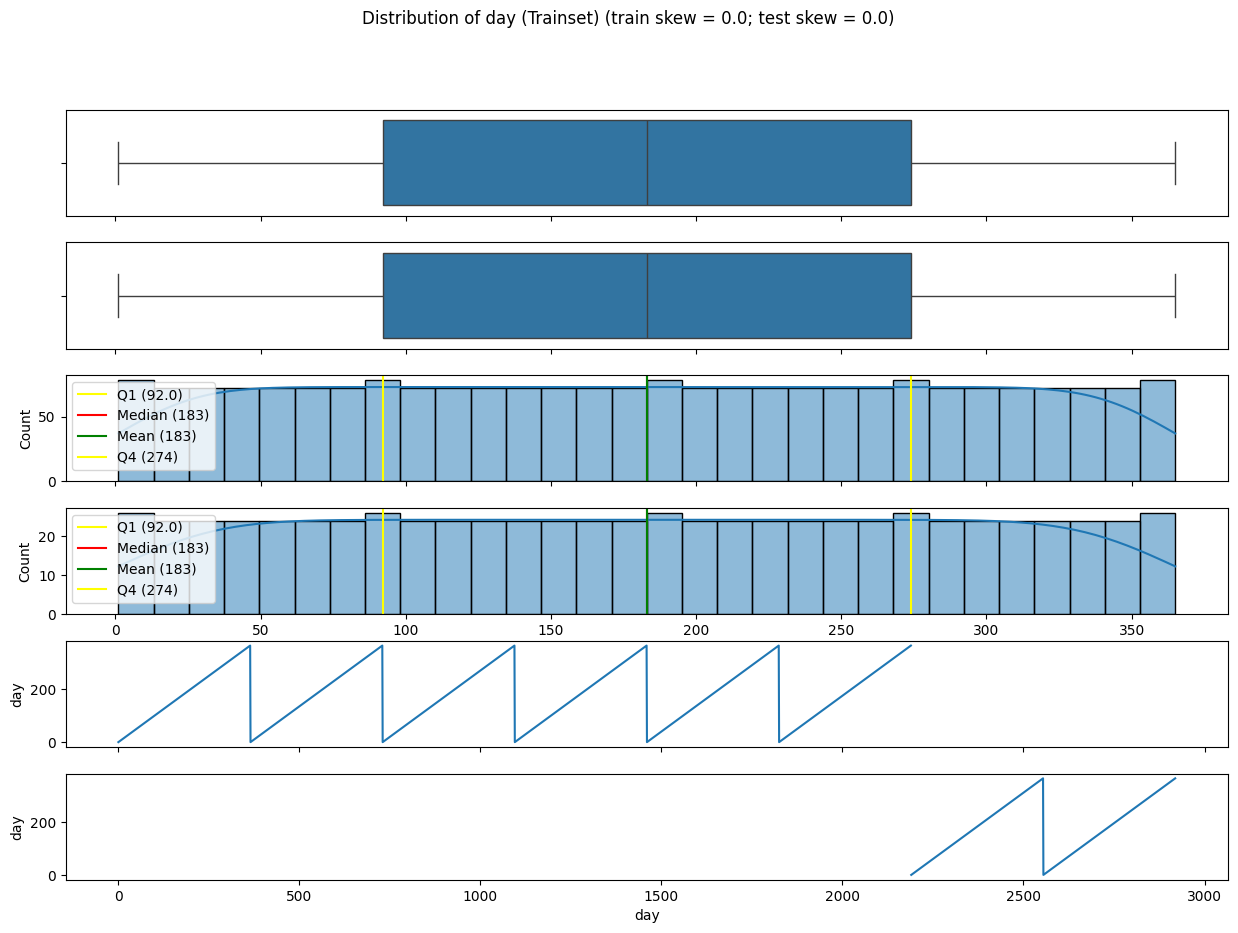

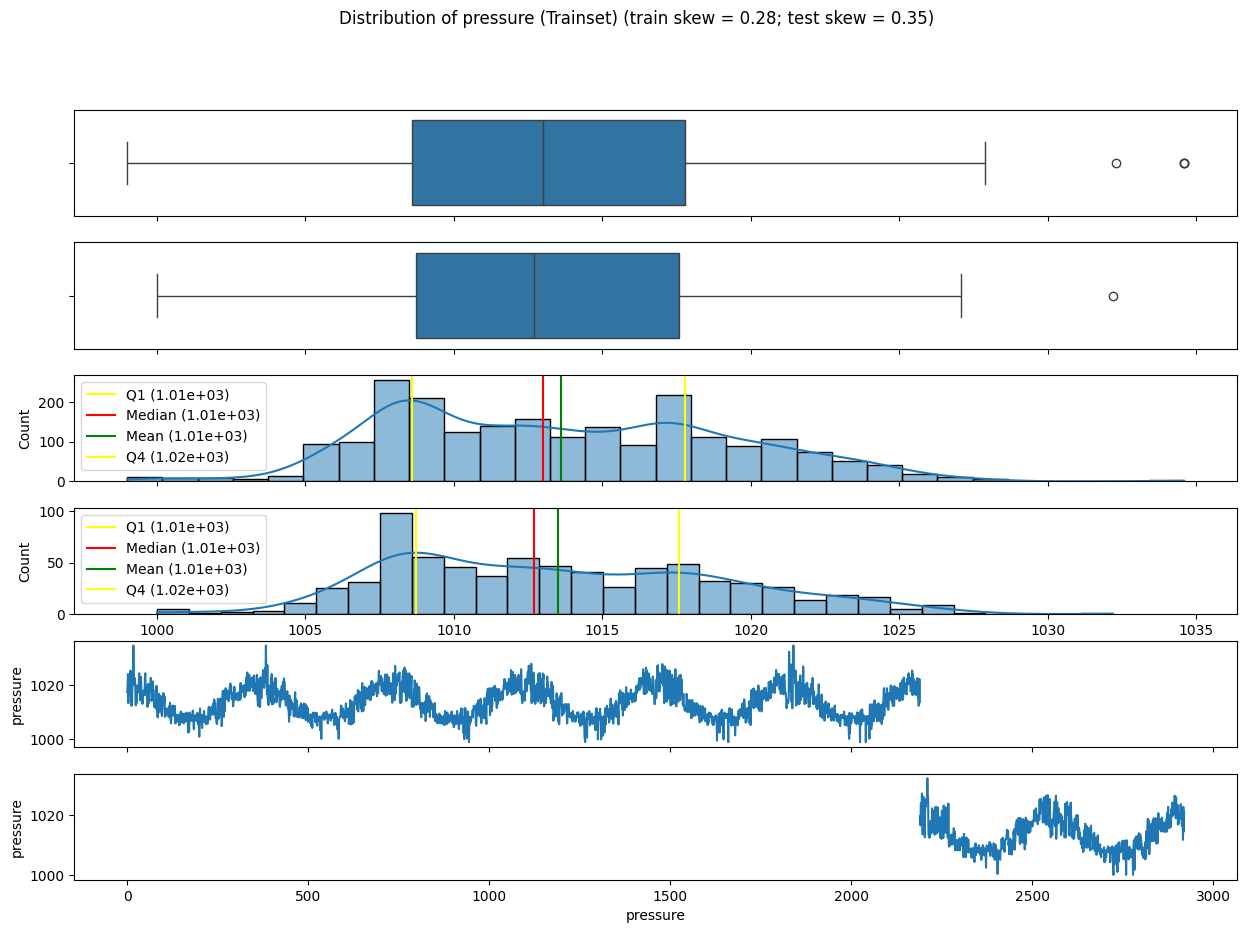

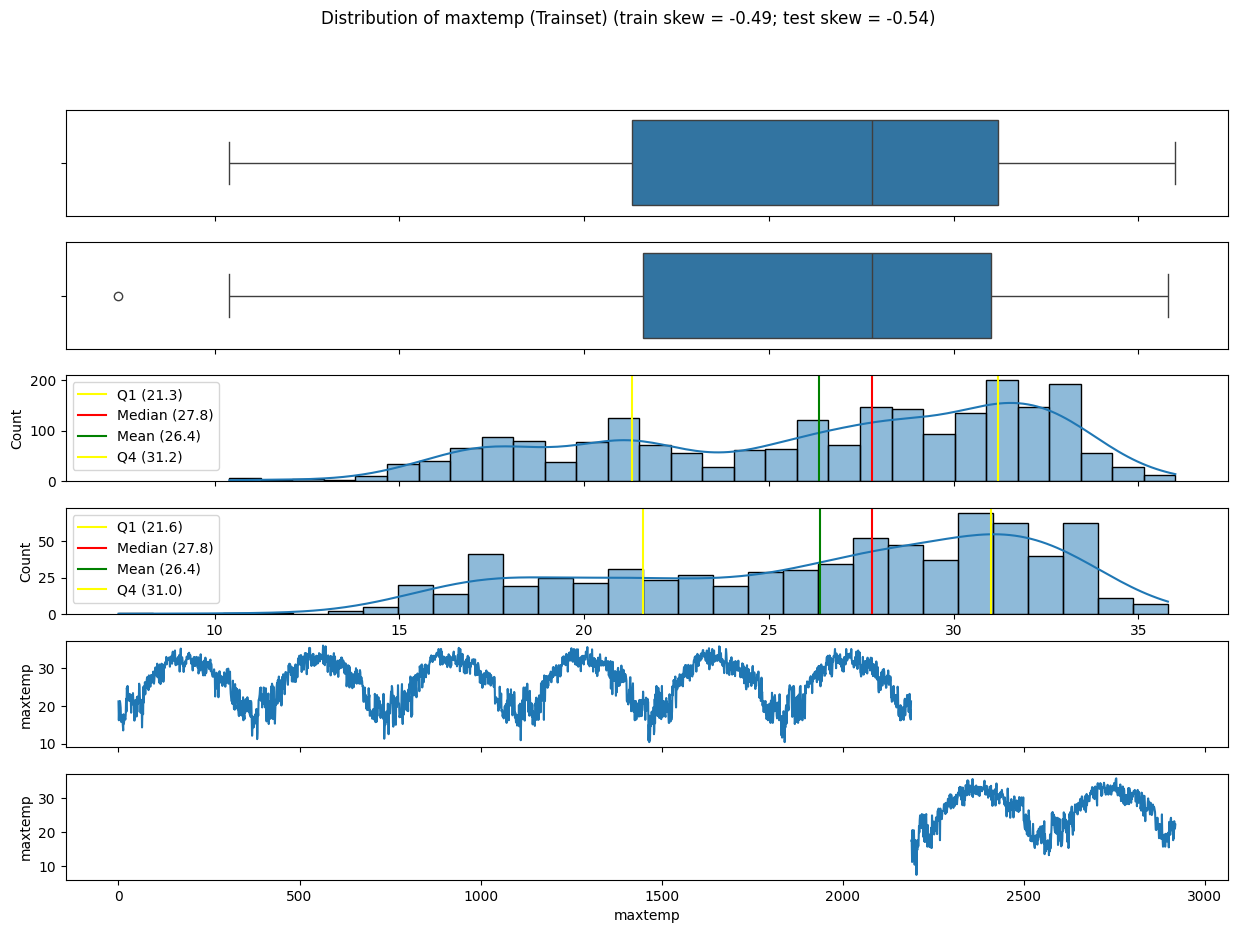

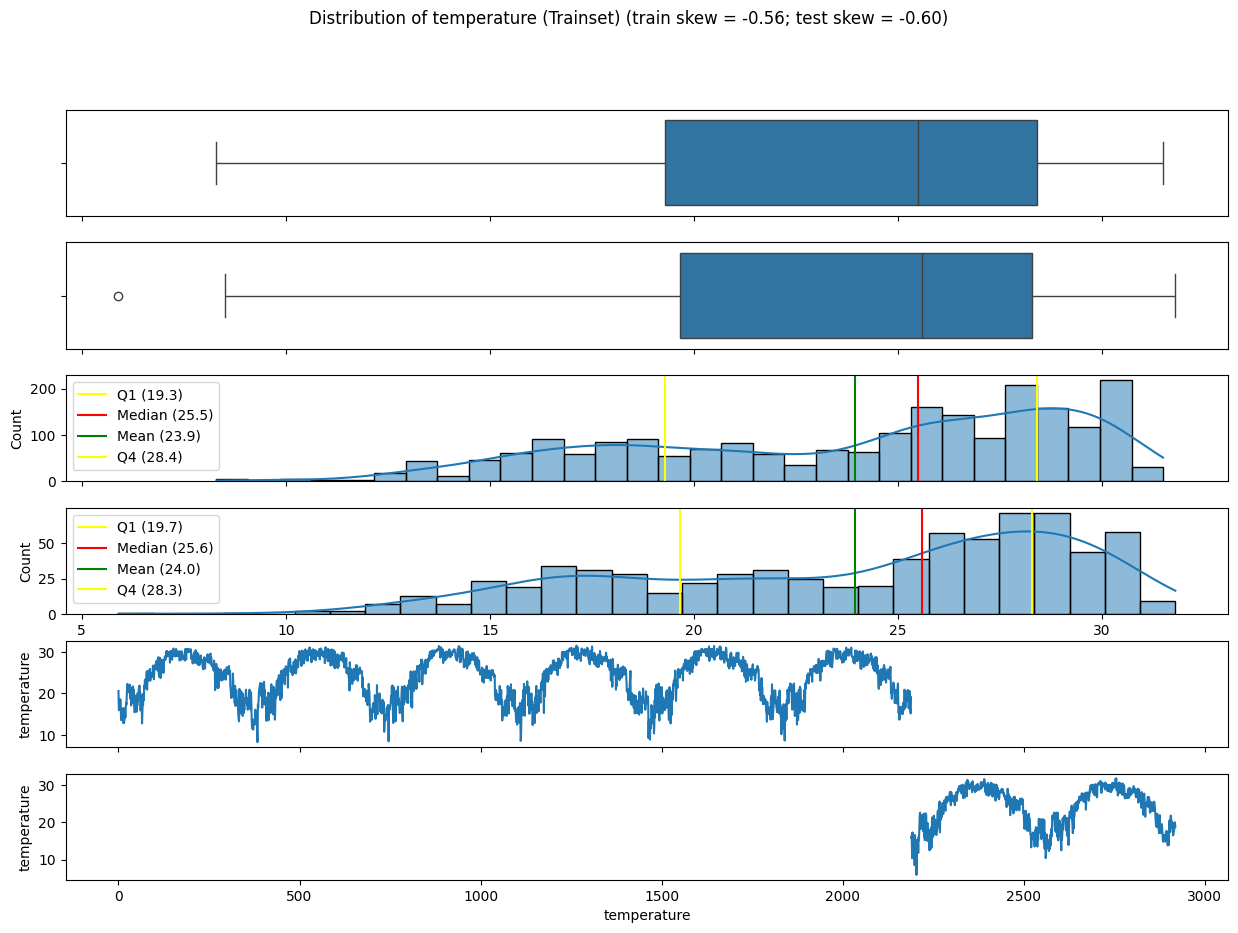

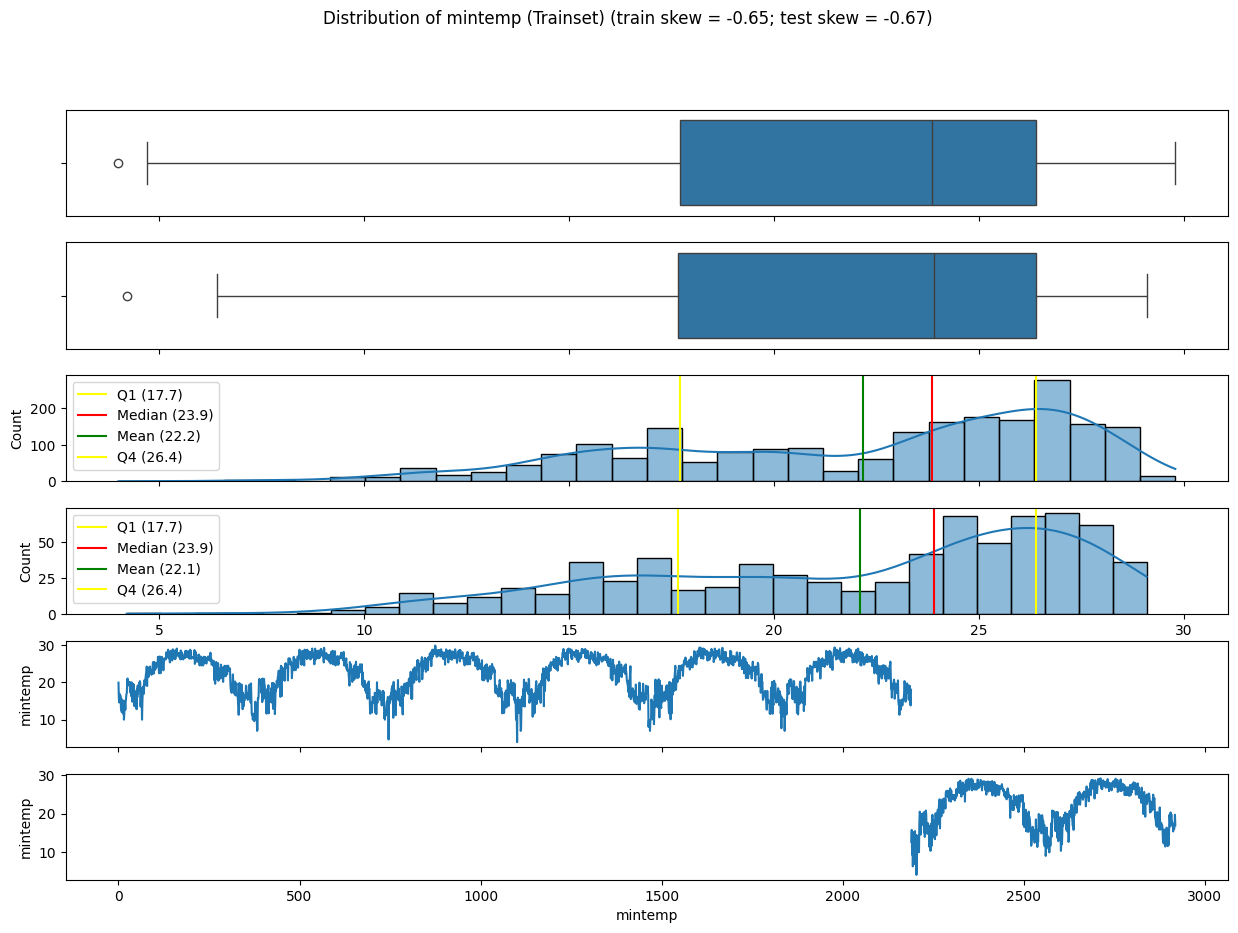

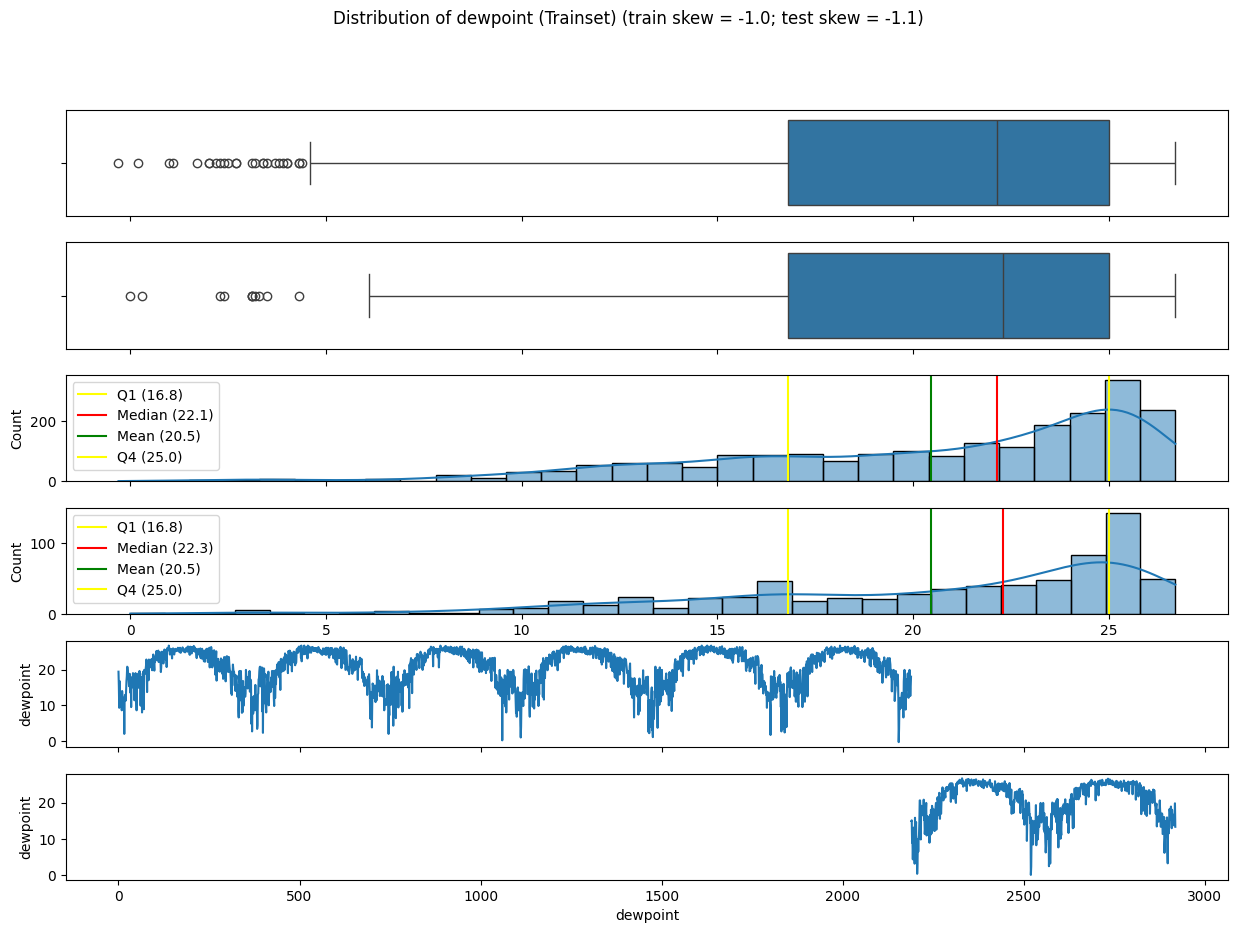

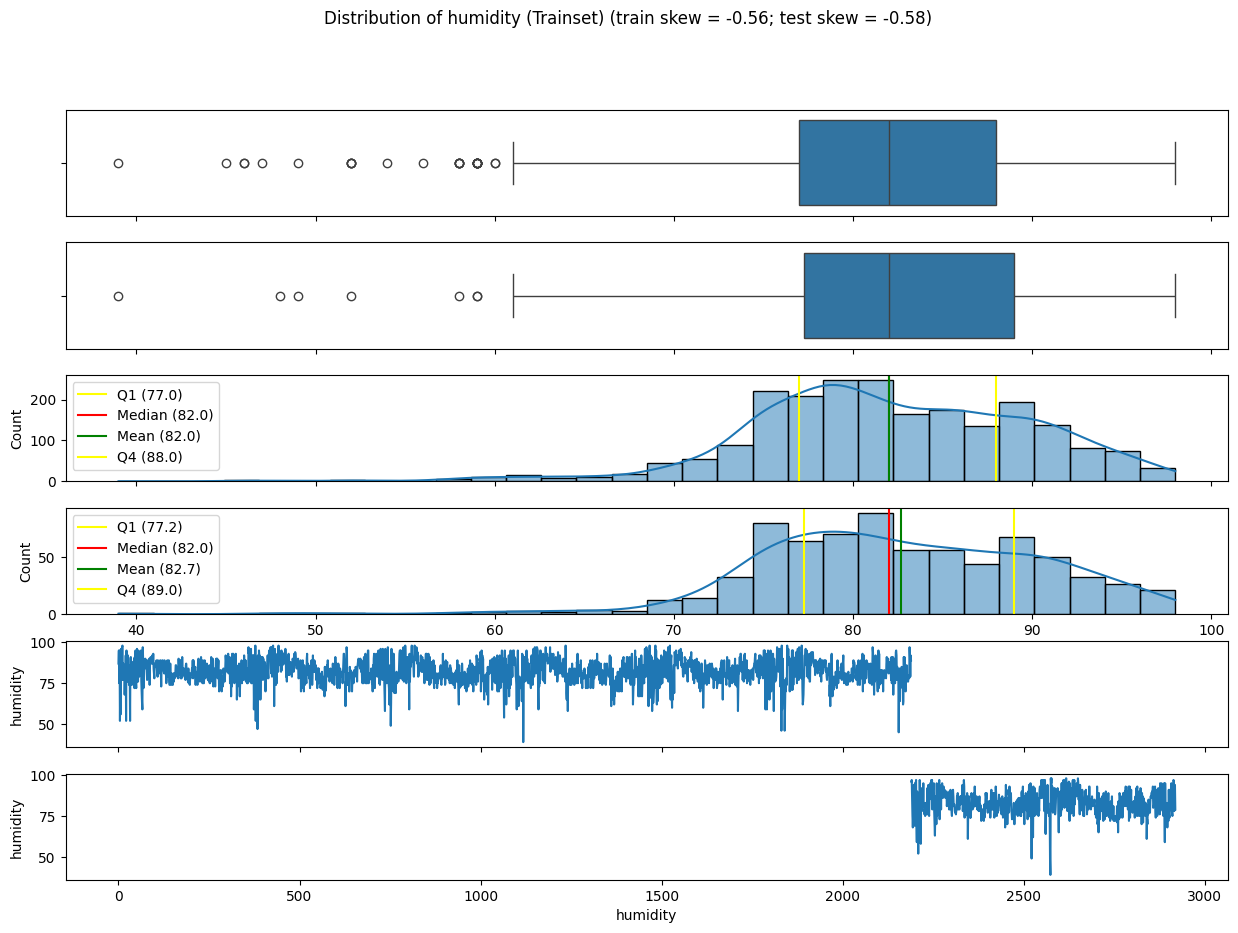

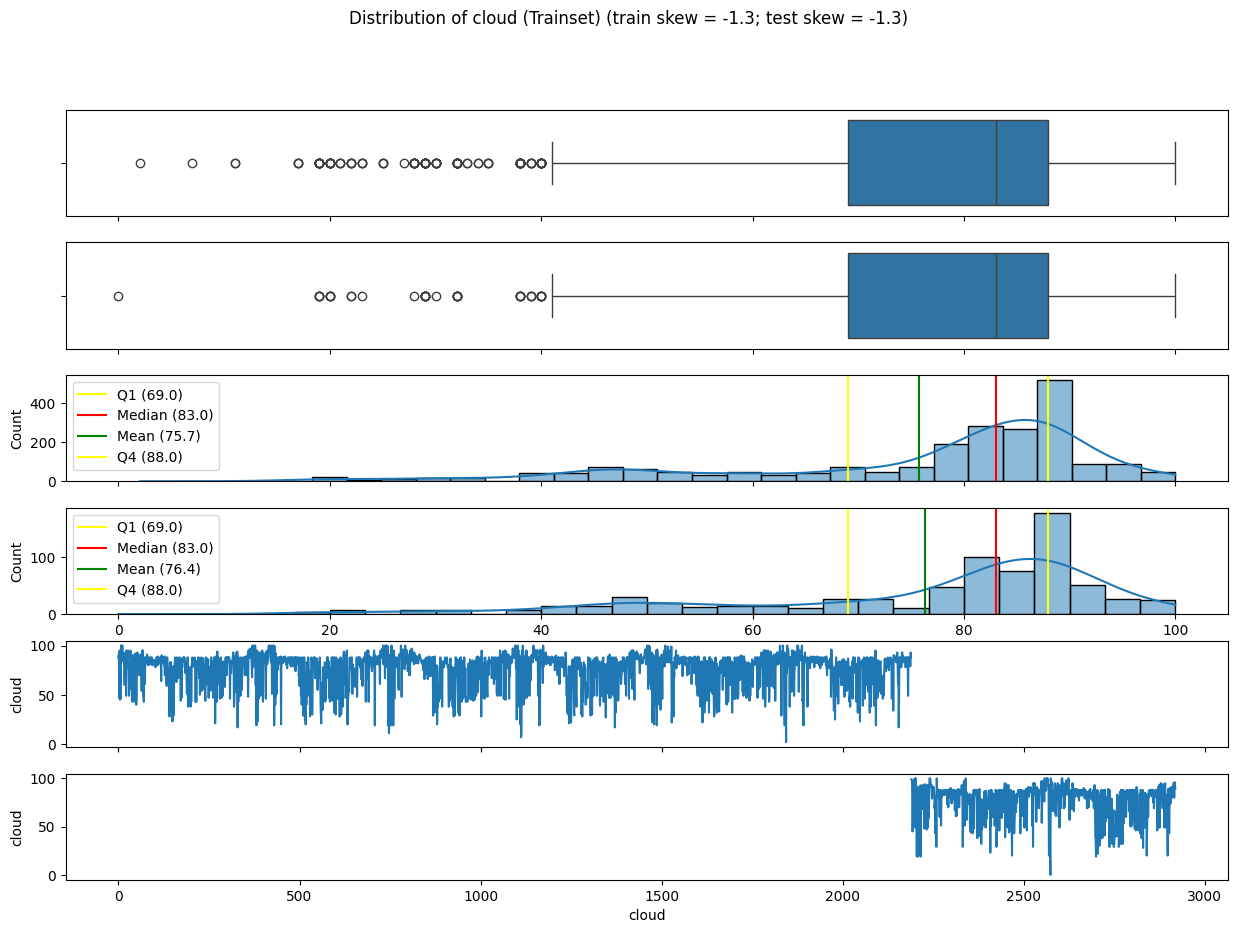

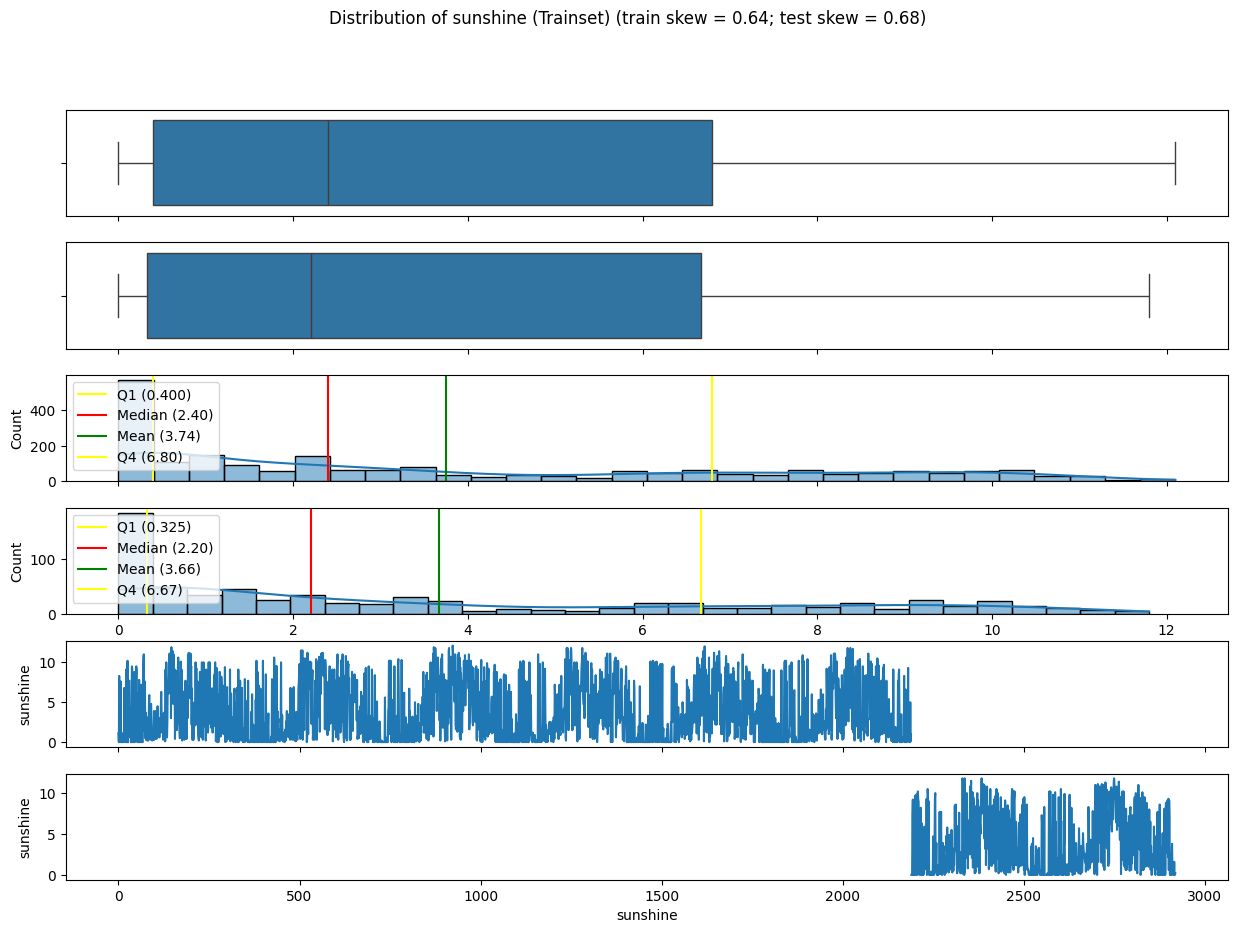

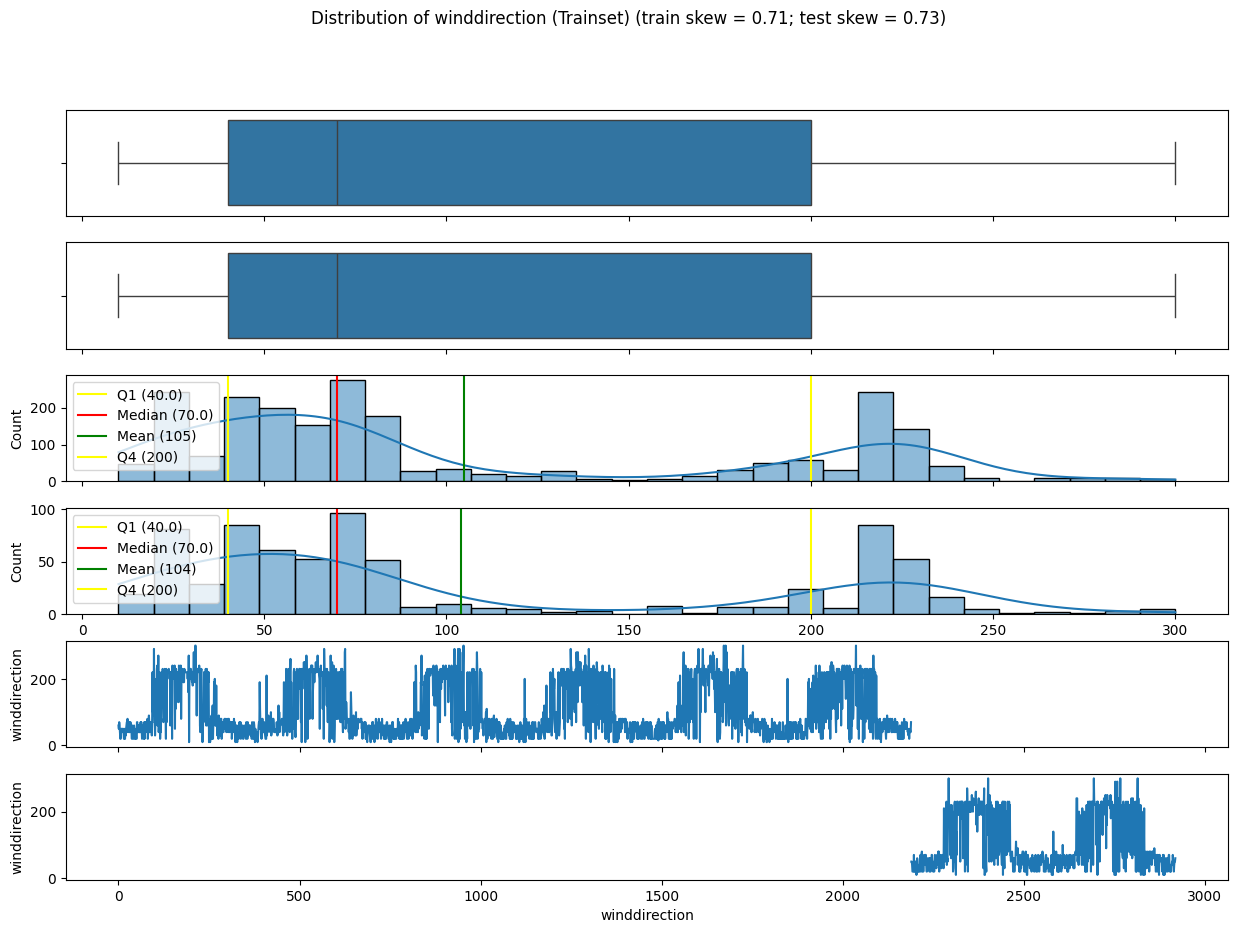

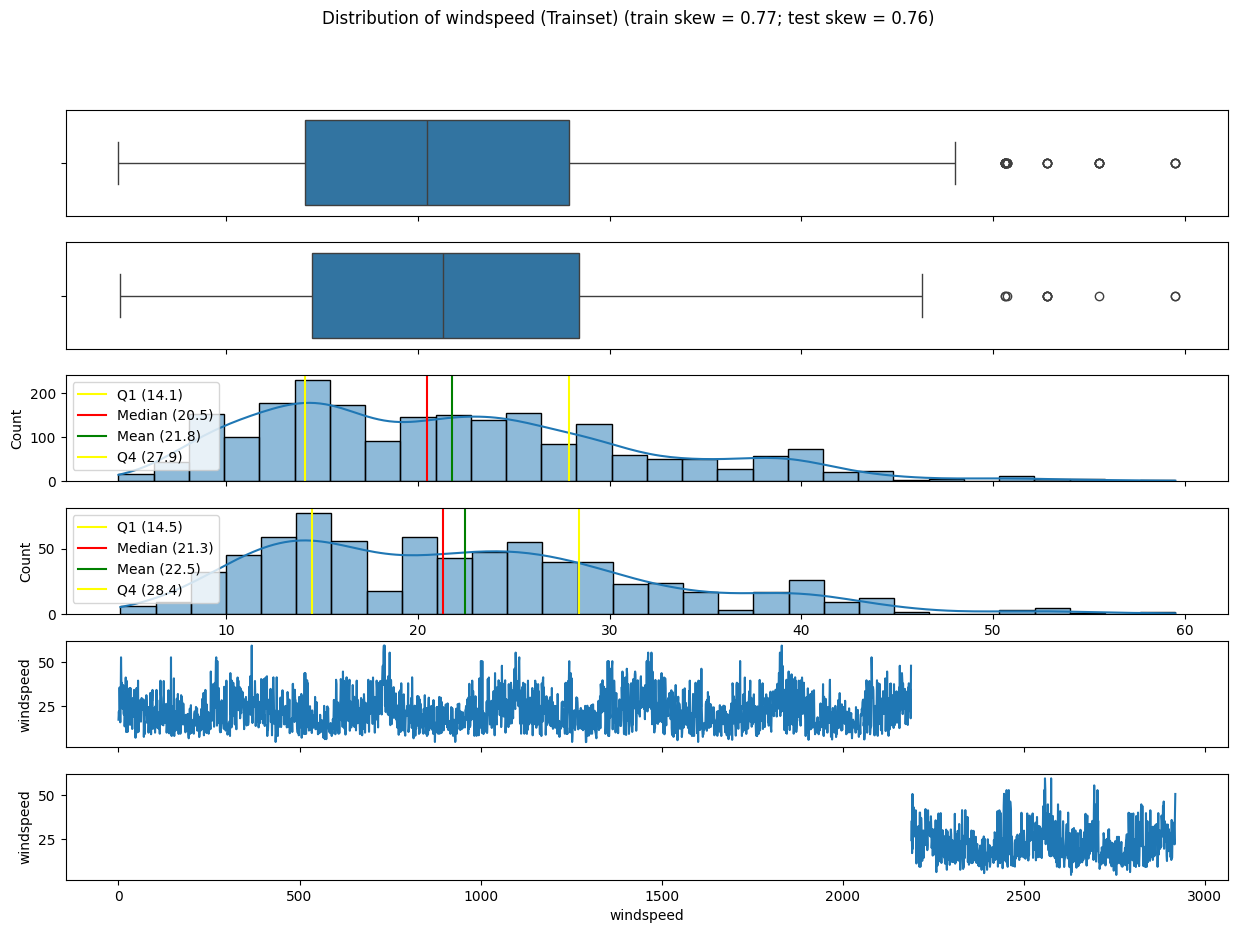

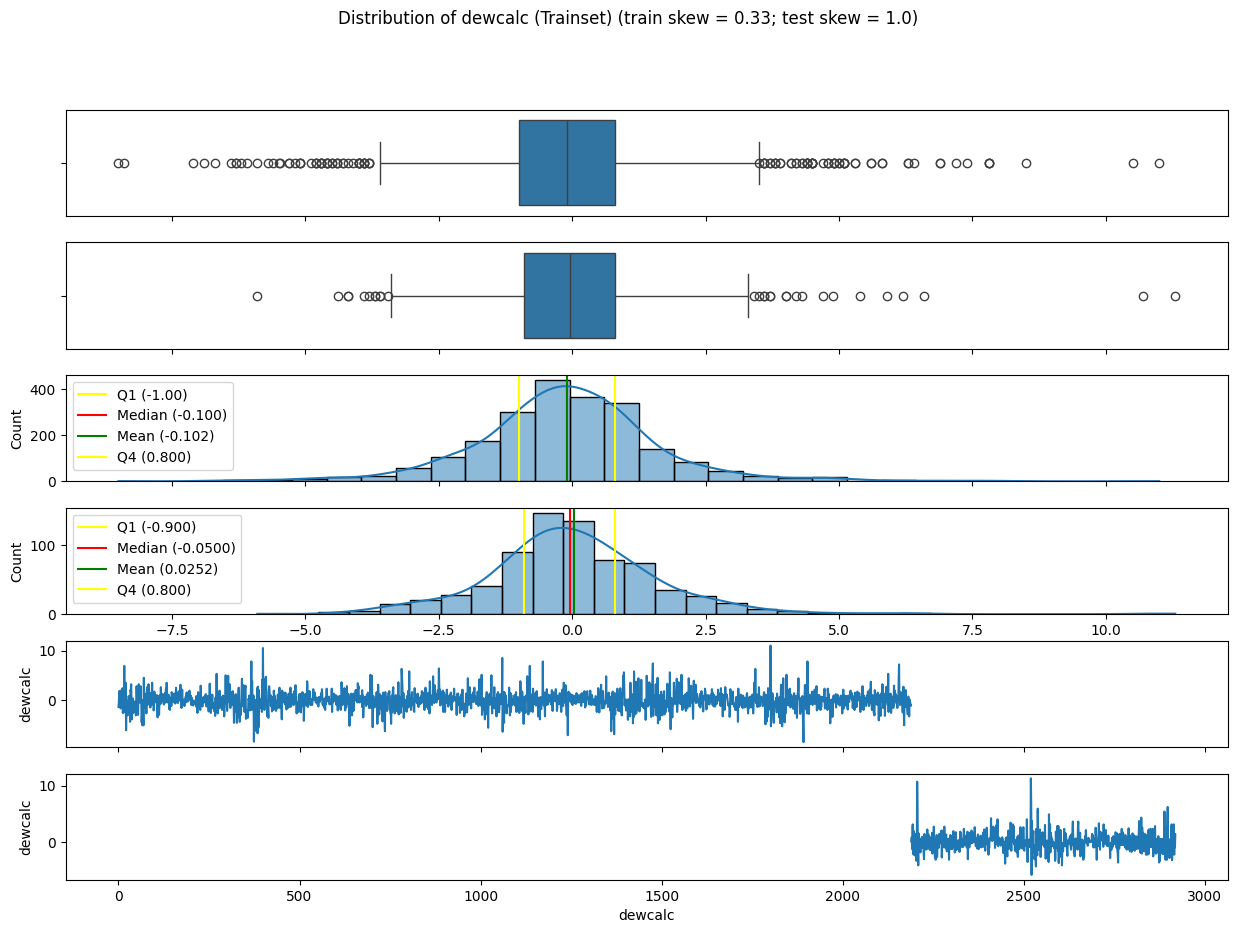

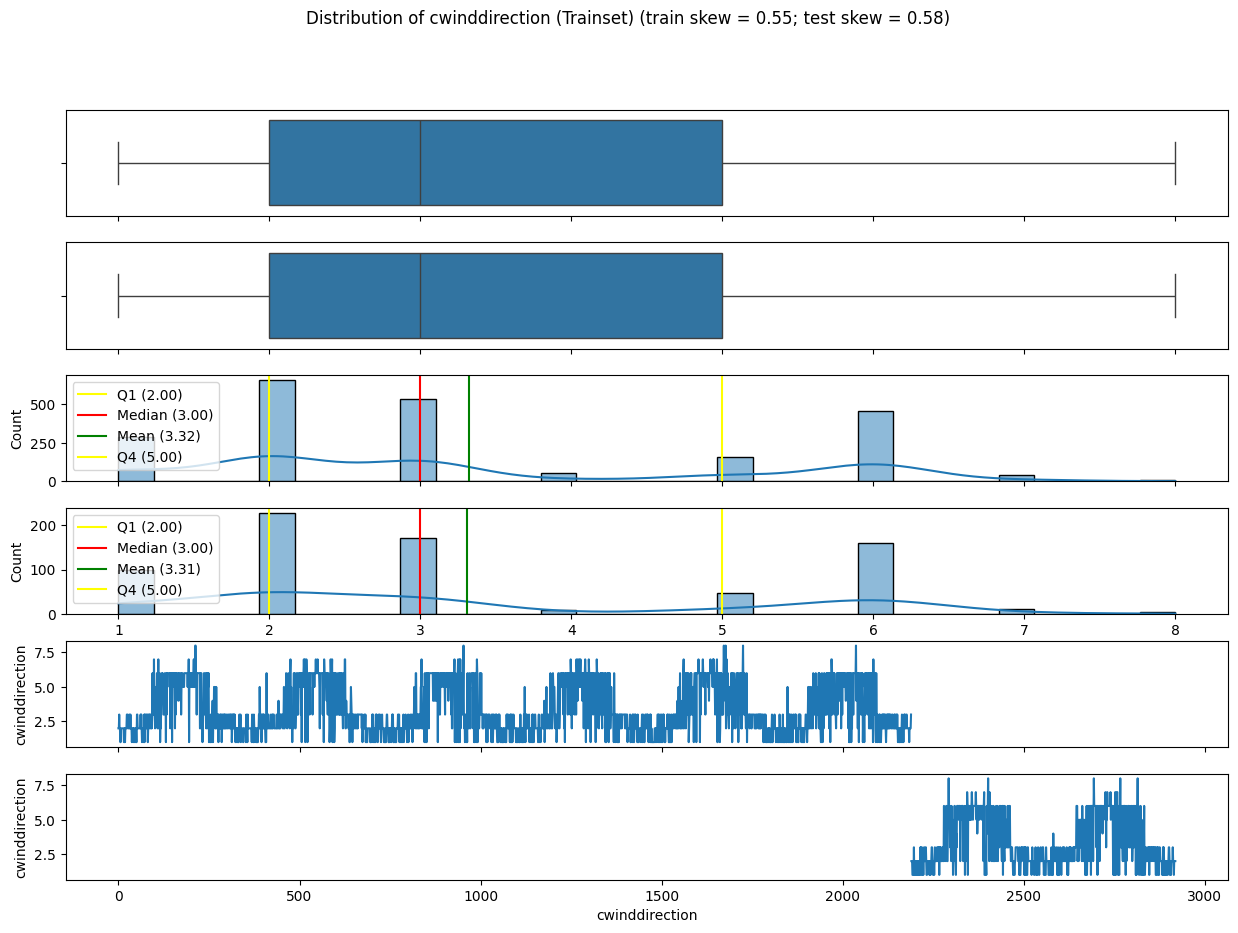

In [36]:
v = train_df.columns.to_list(); v.remove(RAINFALL)
for c in v:
    plot_dist(train_df[c], test_df[c], title=f"Distribution of {c} (Trainset)", xlabel=c)

### **Data Processing**

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day             2190 non-null   int64  
 1   pressure        2190 non-null   float64
 2   maxtemp         2190 non-null   float64
 3   temperature     2190 non-null   float64
 4   mintemp         2190 non-null   float64
 5   dewpoint        2190 non-null   float64
 6   humidity        2190 non-null   float64
 7   cloud           2190 non-null   float64
 8   sunshine        2190 non-null   float64
 9   winddirection   2190 non-null   float64
 10  windspeed       2190 non-null   float64
 11  rainfall        2190 non-null   int64  
 12  dewcalc         2190 non-null   float64
 13  cwinddirection  2190 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 256.6 KB


In [38]:
train_df.query(TEMPERATURE + '==' + MINTEMP)

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc,cwinddirection
id,,,,,,,,,,,,,,
319,320,1018.900,19.200,19.200,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1,-4.600,3
388,24,1015.000,21.600,20.400,20.400,17.400,95.000,88.000,0.500,70.000,20.800,1,2.000,3
1157,63,1015.500,19.900,18.100,18.100,17.100,96.000,92.000,0.200,40.000,14.100,1,0.200,2
1404,310,1014.200,21.300,20.500,20.500,19.900,91.000,88.000,0.000,70.000,46.300,1,-1.200,3
1429,335,1024.300,21.300,19.400,19.400,13.900,91.000,87.000,0.400,50.000,24.400,1,3.700,2
1430,336,1016.800,16.400,15.300,15.300,15.200,86.000,88.000,0.100,50.000,10.900,1,-2.700,2
1868,44,1020.500,15.200,14.600,14.600,12.500,90.000,80.000,0.000,50.000,39.500,1,0.100,2
1910,86,1020.300,27.500,24.400,24.400,20.400,76.000,77.000,1.500,50.000,13.000,1,-0.800,2
1999,175,1009.200,29.500,27.400,27.400,25.900,79.000,60.000,5.100,110.000,11.300,0,-2.700,3


In [39]:
train_df.query(TEMPERATURE + '==' + MAXTEMP)

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc,cwinddirection
id,,,,,,,,,,,,,,
56,57,1012.000,20.900,20.900,19.100,14.900,86.000,80.000,1.600,60.000,13.800,0,3.200,2
319,320,1018.900,19.200,19.200,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1,-4.600,3
726,362,1016.600,17.200,17.200,16.600,16.400,91.000,88.000,0.000,60.000,38.000,1,-1.000,2
1163,69,1017.800,20.100,20.100,19.600,19.800,92.000,83.000,0.300,50.000,16.100,1,-1.300,2
1418,324,1019.900,20.100,20.100,18.000,17.500,93.000,88.000,0.000,25.000,15.300,1,1.200,2
1466,7,1027.400,10.400,10.400,8.100,2.200,77.000,92.000,0.000,60.000,39.500,1,3.600,2
1828,4,1032.300,17.300,17.300,16.700,16.600,73.000,83.000,0.000,30.000,19.300,1,-4.700,2
1911,87,1012.900,25.900,25.900,24.400,23.300,91.000,88.000,1.500,90.000,31.800,1,0.800,3


In [40]:
rainfall_1 = train_df.query(RAINFALL + ' == 1')
rainfall_0 = train_df.query(RAINFALL + ' == 0')

In [41]:
rainfall_1.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc,cwinddirection
count,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000
mean,183.012,1013.441,26.109,23.796,22.092,20.702,84.063,82.333,2.593,104.546,22.437,1.000,-0.094,3.335
std,106.560,5.384,5.529,5.071,4.888,4.952,6.911,11.113,2.886,78.449,9.824,0.000,1.643,1.768
min,1.000,999.000,10.400,8.900,4.000,0.200,58.000,20.000,0.000,10.000,4.500,1.000,-8.400,1.000
25%,92.000,1008.725,21.300,19.311,17.900,16.900,79.000,80.000,0.200,40.000,14.600,1.000,-1.000,2.000
50%,178.000,1013.000,27.600,25.400,23.700,22.250,84.000,85.000,1.500,70.000,21.600,1.000,-0.100,3.000
75%,279.000,1017.500,30.900,28.100,26.300,25.000,89.000,88.000,3.900,190.000,28.400,1.000,0.800,5.000
max,365.000,1034.600,36.000,31.300,29.300,26.700,98.000,100.000,11.800,300.000,59.500,1.000,11.000,8.000


In [42]:
rainfall_0.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc,cwinddirection
count,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000
mean,182.963,1014.095,27.149,24.402,22.407,19.697,75.844,55.522,7.264,105.833,19.874,0.000,-0.126,3.293
std,101.829,6.395,5.959,5.674,5.548,6.148,7.073,19.982,3.384,84.640,9.886,0.000,2.139,1.943
min,4.000,999.000,10.400,8.300,4.700,-0.300,39.000,2.000,0.000,10.000,4.400,0.000,-8.500,1.000
25%,88.750,1008.500,21.600,19.225,17.550,15.450,73.000,43.000,4.975,40.000,12.300,0.000,-1.200,2.000
50%,194.000,1013.150,28.900,26.200,24.500,21.650,76.000,53.000,8.450,70.000,16.900,0.000,-0.100,3.000
75%,265.000,1019.425,32.400,29.625,27.000,24.800,79.000,72.000,10.000,210.000,25.100,0.000,0.800,6.000
max,358.000,1034.600,35.800,31.500,29.800,26.400,94.000,100.000,12.100,300.000,59.500,0.000,10.500,8.000


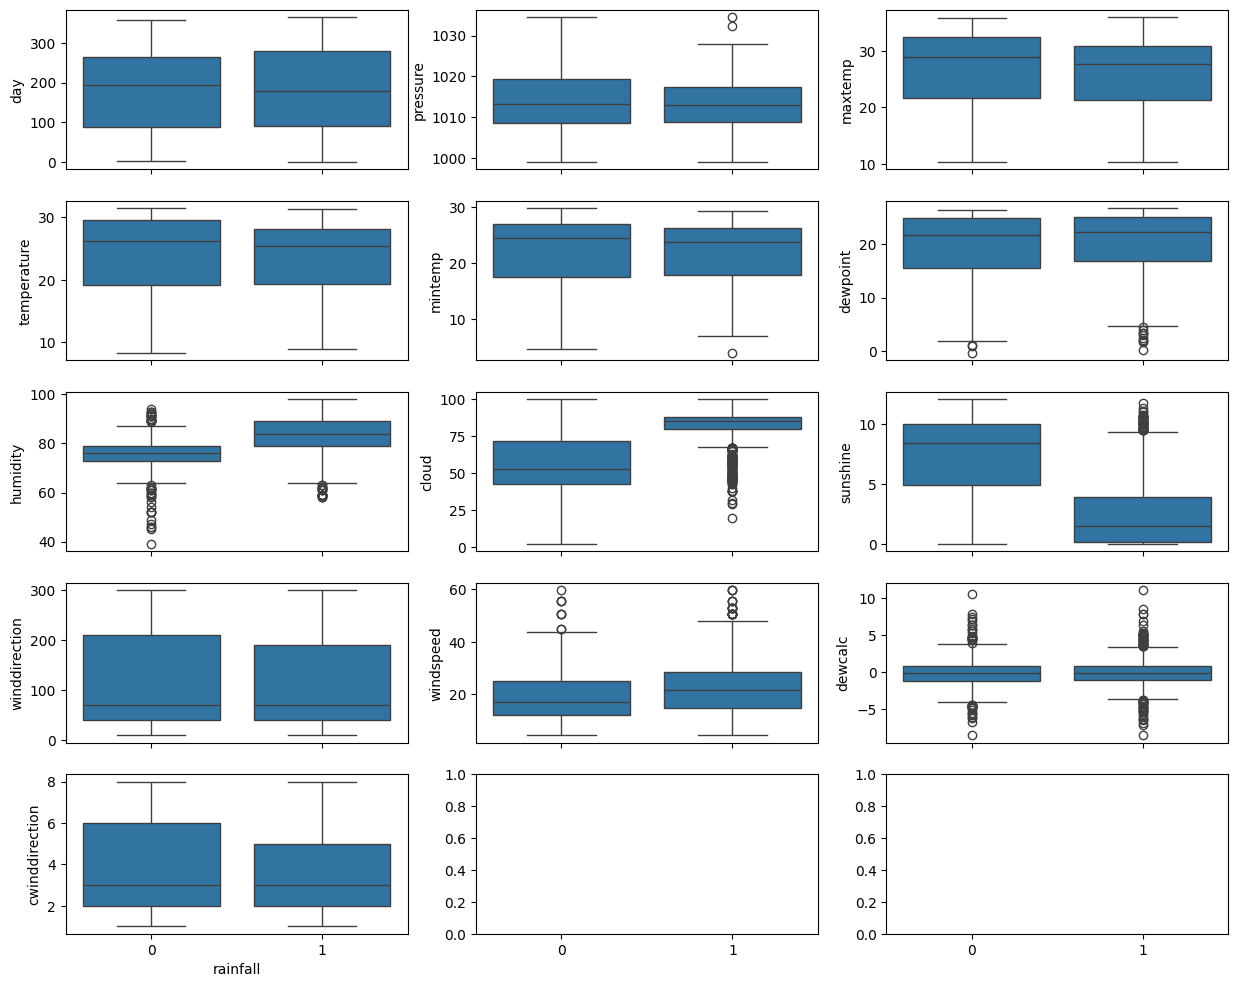

In [43]:
v = train_df.columns.to_list(); v.remove('rainfall')
fig, ax = plt.subplots((len(v)+2)//3, 3, sharex=True, figsize=(3*5,(len(v)+1)//3*3))
for i, c in enumerate(v):
  sns.boxplot(train_df, x='rainfall', y=c, ax=ax[i//3,i%3])
plt.show()

## **Feature Engineering**

In [ ]:
def engineer_features(df):
    """
    Create new features based on meteorological understanding and data analysis,
    with 'day' representing day of the year (1-365).
    Ensures no data leakage by avoiding use of the target variable (rainfall).
    """
    # Make a copy to avoid modifying the original dataframe
    enhanced_df = df.copy()
    
    # 1. Temperature range (difference between max and min temperatures)
    enhanced_df['temp_range'] = enhanced_df[MAXTEMP] - enhanced_df[MINTEMP]
    
    # 2. Dew point depression (difference between temperature and dew point)
    enhanced_df['dewpoint_depression'] = enhanced_df[TEMPERATURE] - enhanced_df[DEWPOINT]
    enhanced_df['dewcalc_depression'] = enhanced_df[TEMPERATURE] - enhanced_df['dewcalc'] + enhanced_df[DEWPOINT]

    # 2.5 
    #enhanced_df['dewpoint_depression'] = enhanced_df['dewpoint_depression'] * enhanced_df[CLOUD]
    
    # 3. Pressure change from previous day
    enhanced_df['pressure_change'] = enhanced_df[PRESSURE].diff().fillna(0)
    
    # 4. Humidity to dew point ratio
    enhanced_df['humidity_dewpoint_ratio'] = enhanced_df[HUMIDITY] / enhanced_df[DEWPOINT].clip(lower=0.1)
    
    # 5. Cloud coverage to sunshine ratio (inverse relationship)
    enhanced_df['cloud_sunshine_ratio'] = enhanced_df[CLOUD] / enhanced_df[SUNSHINE].clip(lower=0.1)
    
    # 6. Wind intensity factor (combination of speed and humidity)
    enhanced_df['wind_humidity_factor'] = enhanced_df[WINDSPEED] * (enhanced_df[HUMIDITY] / 100)
    
    # 7. Temperature-humidity index (simple version of heat index)
    enhanced_df['temp_humidity_index'] = (0.8 * enhanced_df[TEMPERATURE]) + \
                                        ((enhanced_df[HUMIDITY] / 100) * \
                                        (enhanced_df[TEMPERATURE] - 14.3)) + 46.4
    
    # 8. Pressure change rate (acceleration)
    enhanced_df['pressure_acceleration'] = enhanced_df['pressure_change'].diff().fillna(0)
    
    # 9. Seasonal features (based on day of year)
    # Convert day to month (1-365 to 1-12)
    dm = np.array([31,28,31,30,31,30,31,31,30,31,30,31]) # days in each month (for non-leap years).
    enhanced_df['month'] = enhanced_df[DAY].transform(lambda x: ((((x - 1) % 365) + 1) > dm.cumsum()).sum() + 1)
    
    # 10. Convert day to season (1-365 to 1-4)
    enhanced_df['season'] = ((enhanced_df['month'] - 1) // 3) + 1

    # 10.5 Cyloid feature of the temperature and dew temperature.
    enhanced_df['day_of_year_sycl'] = 2 * np.pi * ((enhanced_df[DAY] - 1) % 365 + 1) / 365 - np.sin(2 * np.pi * enhanced_df[DAY] / 365)
    enhanced_df['day_of_year_cycl'] = 1  -  np.cos(2 * np.pi * enhanced_df[DAY] / 365 )
     
    
    # 11. Sine and cosine transformations to capture cyclical nature of pressure in a year
    enhanced_df['day_of_year_sin'] = np.sin(2 * np.pi * enhanced_df[DAY] / 365)
    enhanced_df['day_of_year_cos'] = np.cos(2 * np.pi * enhanced_df[DAY] / 365)
    
    # 12. Rolling averages for key meteorological variables
    for window in [3, 7, 14]:
        enhanced_df[TEMPERATURE   + '_rolling_' + str(window) + 'd'] = enhanced_df[TEMPERATURE].rolling(window=window, min_periods=2, center=True).mean()
        enhanced_df[PRESSURE      + '_rolling_' + str(window) + 'd'] = enhanced_df[PRESSURE].rolling(window=window, min_periods=2, center=True).mean()
        enhanced_df[HUMIDITY      + '_rolling_' + str(window) + 'd'] = enhanced_df[HUMIDITY].rolling(window=window, min_periods=2, center=True).mean()
        enhanced_df[CLOUD         + '_rolling_' + str(window) + 'd'] = enhanced_df[CLOUD].rolling(window=window, min_periods=2, center=True).mean()
        enhanced_df[WINDSPEED     + '_rolling_' + str(window) + 'd'] = enhanced_df[WINDSPEED].rolling(window=window, min_periods=2, center=True).mean()
        enhanced_df[WINDDIRECTION + '_rolling_' + str(window) + 'd'] = enhanced_df[WINDDIRECTION].rolling(window=window, min_periods=2, center=True).mean()

    # 12.5 8- and 3- main wind directions
    for window in [3, 7, 14]:
        enhanced_df['c_' + WINDDIRECTION + '_rolling_' + str(window) + 'd'] = enhanced_df[WINDDIRECTION + '_rolling_' + str(window) + 'd'].transform(
            lambda x: int(((x + 360/8/2) % 360) // (360/8) + 1)
        )
        #enhanced_df['m_' + WINDDIRECTION + '_rolling_' + str(window) + 'd'] = enhanced_df['c_' + WINDDIRECTION + '_rolling_' + str(window) + 'd'].transform(
        #    lambda x: 1 if x in [1, 2, 3] else( 3 if x in [5, 6, 7] else 2)
        #)
    
    # 13. Weather pattern change features
    # Temperature trend
    enhanced_df['temp_trend_3d'] = enhanced_df[TEMPERATURE].diff(3).fillna(0)
    # Pressure trend
    enhanced_df['pressure_trend_3d'] = enhanced_df[PRESSURE].diff(3).fillna(0)
    # Humidity trend
    enhanced_df['humidity_trend_3d'] = enhanced_df[HUMIDITY].diff(3).fillna(0)
    
    # 14. Extreme weather indicators
    enhanced_df['extreme_temp'] = (enhanced_df[TEMPERATURE] > enhanced_df[TEMPERATURE].quantile(0.95)) | \
                                 (enhanced_df[TEMPERATURE] < enhanced_df[TEMPERATURE].quantile(0.05))
    enhanced_df['extreme_temp'] = enhanced_df['extreme_temp'].astype(int)
    
    enhanced_df['extreme_humidity'] = (enhanced_df[HUMIDITY] > enhanced_df[HUMIDITY].quantile(0.95)) | \
                                     (enhanced_df[HUMIDITY] < enhanced_df[HUMIDITY].quantile(0.05))
    enhanced_df['extreme_humidity'] = enhanced_df['extreme_humidity'].astype(int)
    
    enhanced_df['extreme_pressure'] = (enhanced_df[PRESSURE] > enhanced_df[PRESSURE].quantile(0.95)) | \
                                     (enhanced_df[PRESSURE] < enhanced_df[PRESSURE].quantile(0.05))
    enhanced_df['extreme_pressure'] = enhanced_df['extreme_pressure'].astype(int)
    
    # 15. Interaction terms between key variables
    enhanced_df['temp_humidity_interaction'] = enhanced_df[TEMPERATURE] * enhanced_df[HUMIDITY]
    enhanced_df['pressure_wind_interaction'] = enhanced_df[PRESSURE] * enhanced_df[WINDSPEED]
    enhanced_df['cloud_sunshine_interaction'] = enhanced_df[CLOUD] * enhanced_df[SUNSHINE]
    enhanced_df['dewpoint_humidity_interaction'] = enhanced_df[DEWPOINT] * enhanced_df[HUMIDITY]
    
    # 16. Moving standard deviations for measuring variability
    for window in [7, 14]:
        enhanced_df[f'temp_std_{window}d'] = enhanced_df[TEMPERATURE].rolling(window=window, min_periods=4, center=True).std().fillna(0)
        enhanced_df[f'pressure_std_{window}d'] = enhanced_df[PRESSURE].rolling(window=window, min_periods=4, center=True).std().fillna(0)
        enhanced_df[f'humidity_std_{window}d'] = enhanced_df[HUMIDITY].rolling(window=window, min_periods=4, center=True).std().fillna(0)
    
    return enhanced_df
    
#train_df = engineer_features(train_df)
#test_df = engineer_features(test_df)

In [44]:
def generate_features(df_in):

    df = df_in.copy()
    
    ## lag feature
    for lag in [1, 3, 7]:
        df[f'Pressure_lag{lag}'] = df[PRESSURE].shift(lag)
        df[f'Humidity_lag{lag}'] = df[HUMIDITY].shift(lag)

    ## amount of change
    df['Pressure_change_1d'] = df[PRESSURE] - df[PRESSURE].shift(1)
    df['Humidity_change_1d'] = df[HUMIDITY] - df[HUMIDITY].shift(1)

    ## temperature related
    df['Temp_range'] = df[MAXTEMP] - df[MINTEMP]
    df["avg_temp"] = (df[MAXTEMP] + df[MINTEMP]) / 2
    df['Dewpoint_diff'] = df[TEMPERATURE] - df[DEWPOINT]

    ## sunshine, cloud amount
    df['Sunshine_per_hour'] = df[SUNSHINE] / 24
    df['Cloud_per_hour'] = df[CLOUD] / 24
    df['Cloud_Humidity_ratio'] = df[CLOUD] / (df[HUMIDITY] + 1e-5)
    df['Cloud_Sunshine_ratio'] = df[CLOUD] / (df[SUNSHINE] + 1e-5)

    ## wind related
    df['Wind_x'] = df['windspeed'] * np.cos(np.radians(df[WINDDIRECTION]))
    df['Wind_y'] = df['windspeed'] * np.sin(np.radians(df[WINDDIRECTION]))

    ## others
    df['humidity_cloud_interaction'] = df[HUMIDITY] * df[CLOUD]
    df['humidity_sunshine_interaction'] = df[HUMIDITY] * df[SUNSHINE]
    df['Pressure_Humidity_Interaction'] = df[PRESSURE] * df[HUMIDITY]
    df["cloud_wind_interaction"] = df[CLOUD] * df[WINDSPEED]
    df['relative_dryness'] = 100 - df[HUMIDITY]
    df['sunshine_percentage'] = df[SUNSHINE] / (df[SUNSHINE] + df[CLOUD] + 1e-5)
    df['cloud_percentage'] = df[CLOUD] / (df[SUNSHINE] + df[CLOUD] + 1e-5)
    df['weather_index'] = (0.4 * df[HUMIDITY]) + (0.3 * df[CLOUD]) - (0.3 * df[SUNSHINE])
    df['Temp_Ratio'] = df[TEMPERATURE] / df[MAXTEMP].max()

    # df['humidity_index'] = df[DEWPOINT] / df[MAXTEMP]
    # df['High_Cloud_Cover'] = (df[CLOUD] > 60).astype(int)
    # df['High_Humidity'] = (df[HUMIDITY] > 75).astype(int)

    # df['cloud_plus_humidity'] = df[CLOUD] + df[HUMIDITY]
    # df['humidity_plus_sunshine'] = df[HUMIDITY] + df[SUNSHINE]
    # df['Pressure_plus_Humidity'] = df[PRESSURE] + df[HUMIDITY]
    # df['sunshine_under_4'] = df[SUNSHINE].apply(lambda x: 1 if x <= 4.0 else 0)

    df['Try'] = (df[HUMIDITY] + df[CLOUD] + df[DEWPOINT])
    df['Try_2'] = (df[CLOUD] - df[SUNSHINE]) + df[TEMPERATURE]

    # wet-bulb temperature
    def calc_wet_bulb(T, RH):
        return T * np.arctan(0.151977 * np.sqrt(RH + 8.313659)) + \
               np.arctan(T + RH) - np.arctan(RH - 1.676331) + \
               0.00391838 * RH**(3/2) * np.arctan(0.023101 * RH) - 4.686035

    df['wet_bulb_temp'] = calc_wet_bulb(df[TEMPERATURE], df[HUMIDITY])

    # saturated vapor pressure
    def calc_saturation_vapor_pressure(temp):
        return 6.11 * np.exp((17.27 * temp) / (temp + 237.3))

    df['e_s_temp'] = calc_saturation_vapor_pressure(df[TEMPERATURE])
    df['e_s_dewpoint'] = calc_saturation_vapor_pressure(df[DEWPOINT])

    # vapor pressure deficit
    df['vapor_pressure_deficit'] = df['e_s_temp'] - df['e_s_dewpoint']

    df.fillna(method='bfill', inplace=True)

    return df
train_df = generate_features(train_df)
test_df = generate_features(test_df)

/tmp/ipykernel_32679/2575241204.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_32679/2575241204.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [45]:
columns = train_df.columns.to_list()
columns.remove('rainfall')

sc = StandardScaler()

train_scaled = train_df.copy()
test_scaled = test_df.copy()
train_scaled[columns]=sc.fit_transform(train_df[columns])
test_scaled[columns]=sc.transform(test_df[columns])

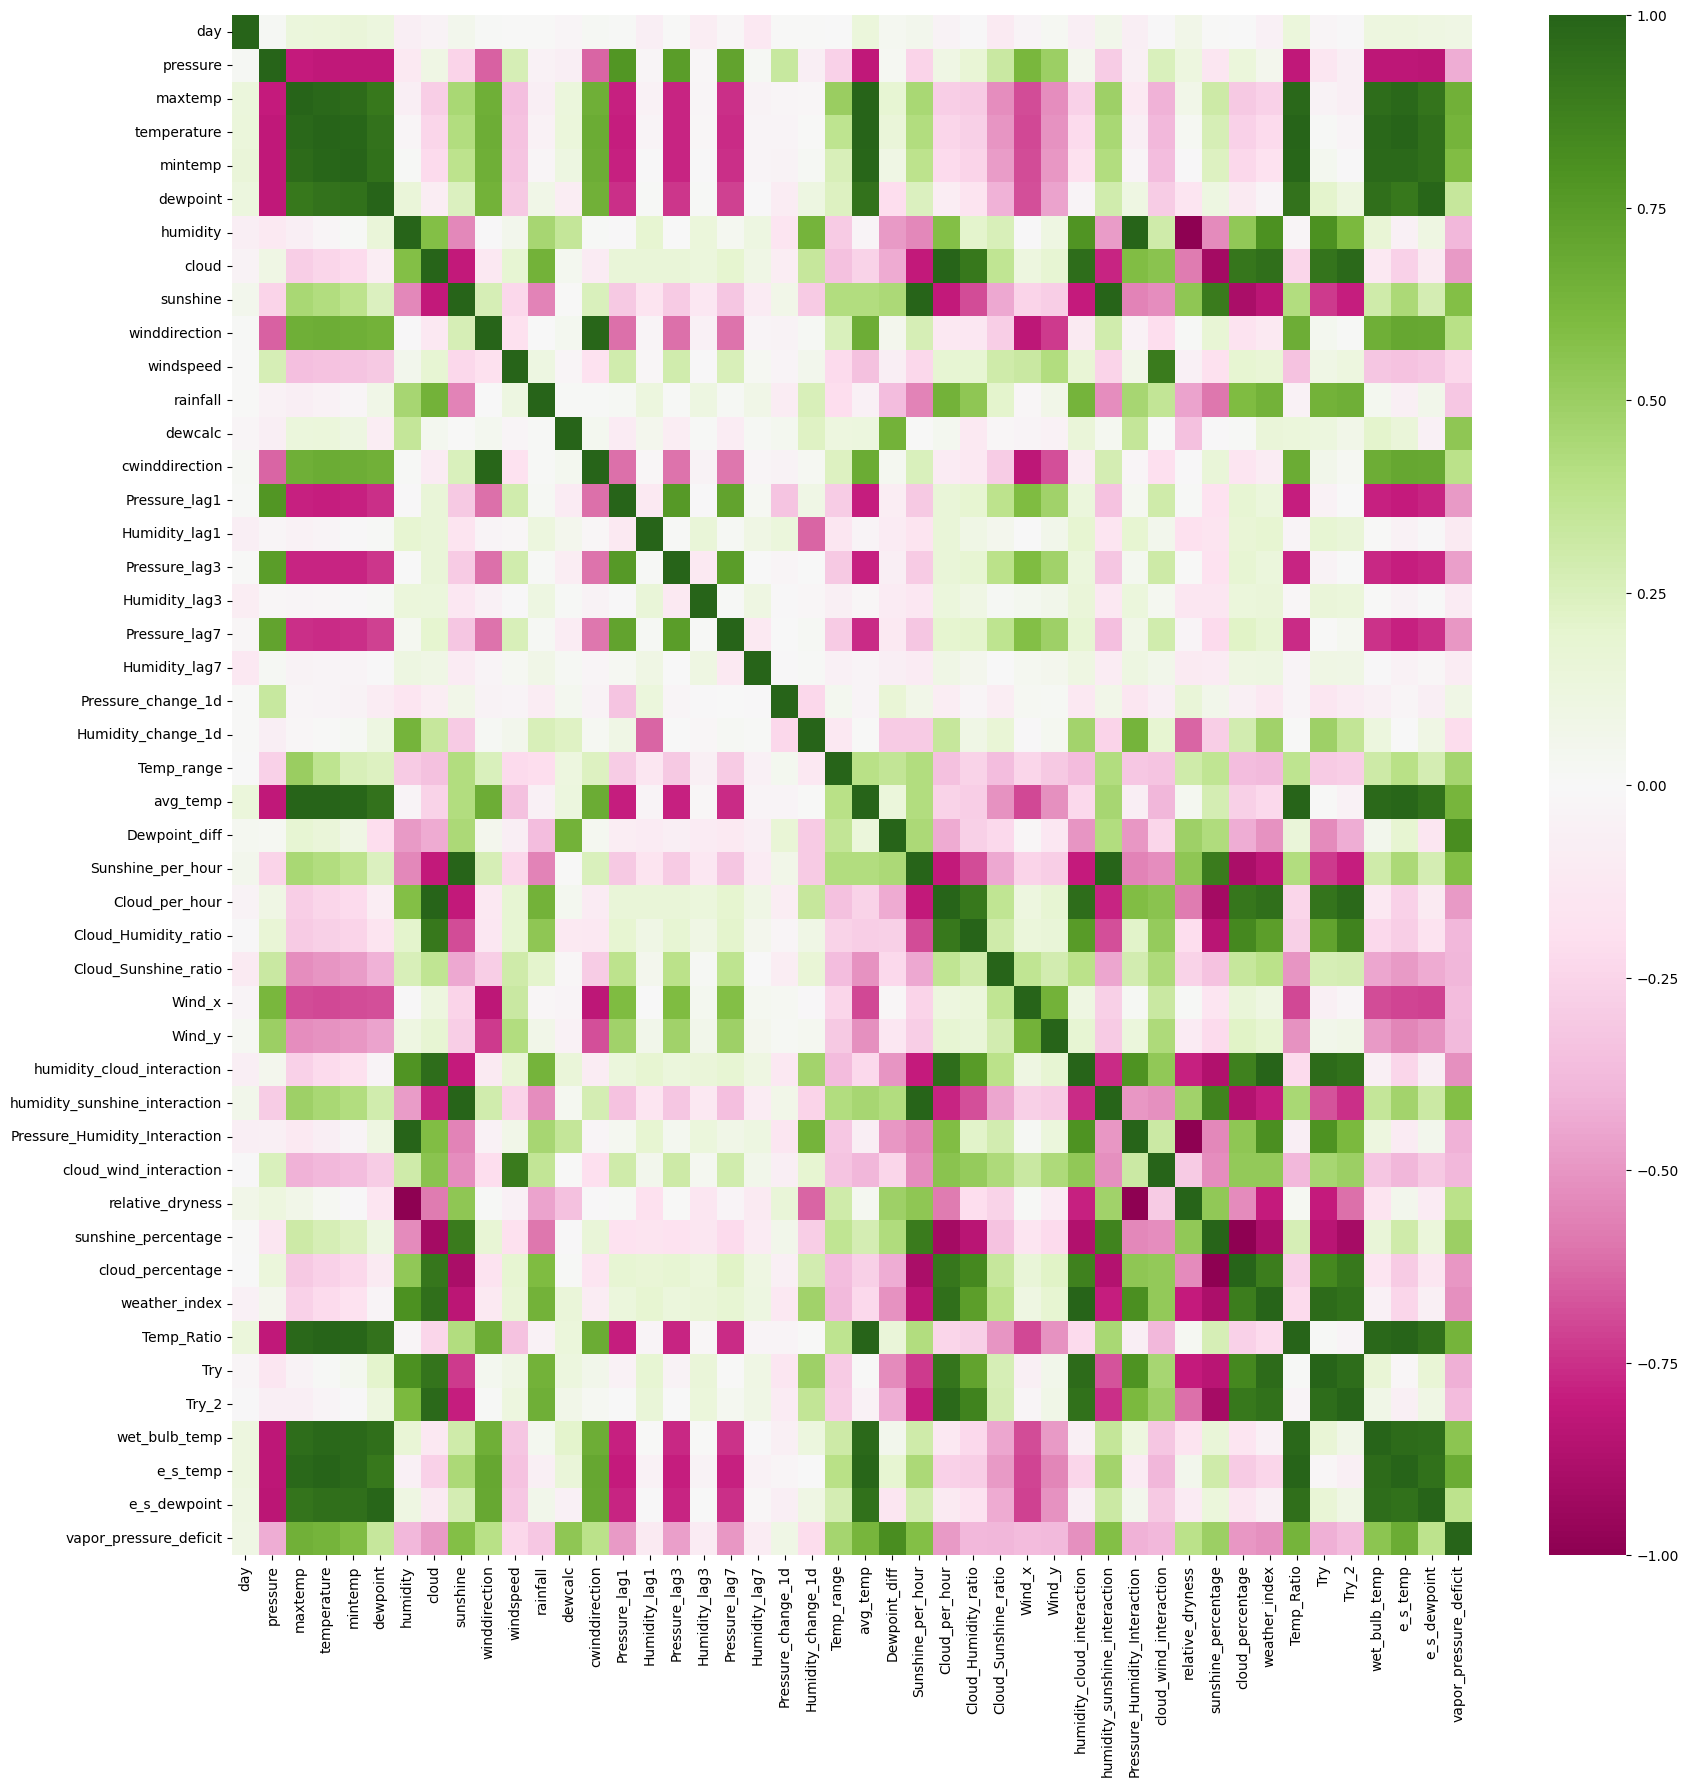

In [46]:
plt.figure(figsize  = (20, 20))

num_cols = train_scaled.select_dtypes(include = "number").columns.to_list()

sns.heatmap(train_scaled[num_cols].corr(), annot = False, vmin=-1, vmax=1, cmap = "PiYG")

plt.show()

## **Model Evaluation**

In [47]:
# Creating metric function

def metrics_score(actual, predicted, target_column=None):

    print(classification_report(actual, predicted, digits=6))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    # Lets use labels that make sense (if target_column supplied)
    nan_lb = 'NaN'
    n = cm.shape[0]
    if target_column:
        match target_column:
            case RAINFALL:
                axlb = ['Dry', 'Rain']
    else:
        axlb = [''] * n
    if n == 3: axlb = [nan_lb, *axlb] if target_column else [nan_lb, *axlb[1:]]

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = axlb, yticklabels = axlb)

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()
    return classification_report(actual, predicted, digits=6, output_dict=True)['accuracy']

In [48]:
def model_performance_classification(model, predictors, target, ret_df=True):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall

    precision = precision_score(target, pred, average = 'macro')              # To compute precision

    acc = accuracy_score(target, pred)                                 # To compute accuracy score

    dict_perf = {"Precision": precision, "Recall": recall, "Accuracy": acc}

    if ret_df:
        # Creating a dataframe of metrics
        return pd.DataFrame(dict_perf, index = [0])

    # Creating a dictionary of metrics
    return dict_perf

In [49]:
def xgb_scores(estimator, X_train, X_test, y_train, y_test):
    train_score = estimator.score(X_train, y_train)
    sc_df_train = model_performance_classification(estimator,X_train, y_train, ret_df=False)

    test_score = estimator.score(X_test, y_test)
    sc_df_test = model_performance_classification(estimator,X_test, y_test, ret_df=False)

    print(f"""Model metrics:
    TRAIN ({(train_score+sum(sc_df_train.values()))/4.0:.3f}):\
    Score = {train_score:.3f}, Precision = {sc_df_train['Precision']:.3f}, Recall = {sc_df_train['Recall']:.3f}, Accuracy = {sc_df_train['Accuracy']:.3f}
    TEST  ({(test_score+sum(sc_df_test.values()))/4.0:.3f}):\
    Score = {test_score:.3f}, Precision = {sc_df_test['Precision']:.3f}, Recall = {sc_df_test['Recall']:.3f}, Accuracy = {sc_df_test['Accuracy']:.3f}
    """)

    return train_score, test_score, sc_df_train, sc_df_test

def simple_XGB_optimation(xgb,X,y,cv):
    Xv = X if isinstance(X, np.ndarray) else X.values
    yv = y if isinstance(y, np.ndarray) else y.values
    results = {}
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train = Xv[train]
        X_test = Xv[test]
        y_train = yv[train]
        y_test = yv[test]
        est = clone(xgb)
        est.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        train_score, test_score, m_train_sc, m_test_sc = xgb_scores(
            est, X_train, X_test, y_train, y_test
        )
        results[i] = (est, train_score, test_score, m_train_sc, m_test_sc)
    # Choose the model with the best score (as the sum of all metrics)
    m = max(results.values(),key=lambda v: v[1]+v[2]+sum(v[3].values())+sum(v[4].values()))
    trs, tss, tr_m, ts_m = m[1:]
    print(f"""Metrics for best XGBoost model:
    TRAIN ({(trs+sum(tr_m.values()))/4.0:.3f}):  Score = {trs:.3f}, Precision = {tr_m['Precision']:.3f}, Recall = {tr_m['Recall']:.3f}, Accuracy = {tr_m['Accuracy']:.3f}
    TEST  ({(tss+sum(ts_m.values()))/4.0:.3f}):  Score = {tss:.3f}, Precision = {ts_m['Precision']:.3f}, Recall = {ts_m['Recall']:.3f}, Accuracy = {ts_m['Accuracy']:.3f}
    """)
    return m[0]

## **Splitting the dataset**

In [50]:
train_final = train_scaled.copy()
test_final = test_scaled.copy()

In [51]:
# Create train and val datasets
test_size = .2
target_column = RAINFALL

columns = train_final.columns.to_list()
columns.remove(target_column)

X = train_final[columns]
y = train_final[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=31)

np.random.seed(0)

## **Build Models**

### **Random Forest**

In [52]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(X_train, y_train)

In [53]:
# Checking performance on the test data
y_pred_test_rf = rf.predict_proba(X_val)

rf_score = roc_auc_score(y_val, y_pred_test_rf[:,1])
rf_score

0.9120710059171597

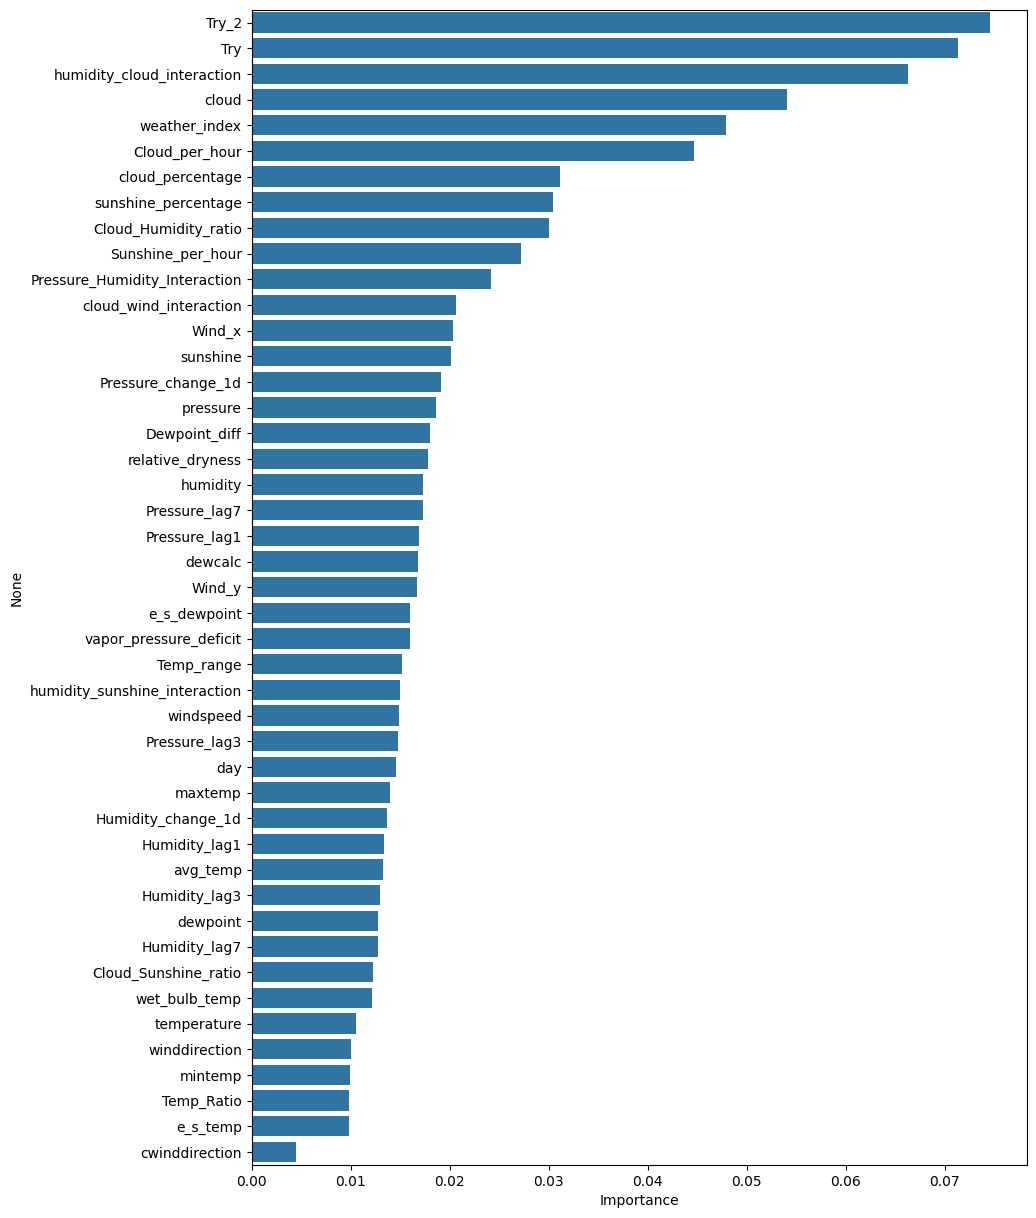

In [54]:
# Plot the feature importance
f, ax = plt.subplots(1,1,figsize=(10,15))

importances = rf.feature_importances_

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

sns.barplot(x=importance_df.Importance,y=importance_df.index,ax=ax);

In [55]:
submission = pd.read_csv(path_input + "/sample_submission.csv")
submission['rainfall'] = 1 - rf.predict_proba(test_final)
submission.to_csv('/'.join([path_output,'submission.csv']), index = False)

In [56]:
# Select only the best attributes
#selected_columns = importance_df.loc[importance_df['Importance'] >= 0.013].index.to_list()
#columns = selected_columns
#train_final = train_final[[*columns,target_column]]
#test_final = test_final[columns]
#X = X[columns]
#X_train = X_train[columns]
#X_val = X_val[columns]

In [57]:
#selected_columns,len(selected_columns)

### **XGBoost**

In [58]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  objective = 'binary:logistic',  # Changed to binary objective
  eval_metric = 'auc',  # Changed to binary error
  #eval_metric = "logloss", # For multi-class use mlogloss
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

[0]	validation_0-auc:0.83648
[1]	validation_0-auc:0.86153
[2]	validation_0-auc:0.86841
[3]	validation_0-auc:0.85965
[4]	validation_0-auc:0.85535
[5]	validation_0-auc:0.85344
[6]	validation_0-auc:0.85489
Model metrics:
    TRAIN (0.901):    Score = 0.917, Precision = 0.919, Recall = 0.853, Accuracy = 0.917
    TEST  (0.820):    Score = 0.852, Precision = 0.821, Recall = 0.756, Accuracy = 0.852
    
[0]	validation_0-auc:0.86514
[1]	validation_0-auc:0.87406
[2]	validation_0-auc:0.87283
[3]	validation_0-auc:0.88385
[4]	validation_0-auc:0.88769
[5]	validation_0-auc:0.89094
[6]	validation_0-auc:0.89401
[7]	validation_0-auc:0.89653
[8]	validation_0-auc:0.89589
[9]	validation_0-auc:0.89426
[10]	validation_0-auc:0.89264
[11]	validation_0-auc:0.89183
Model metrics:
    TRAIN (0.926):    Score = 0.938, Precision = 0.935, Recall = 0.894, Accuracy = 0.938
    TEST  (0.848):    Score = 0.873, Precision = 0.835, Recall = 0.813, Accuracy = 0.873
    
[0]	validation_0-auc:0.86035
[1]	validation_0-auc:0

In [59]:
# Checking performance on the test data
y_pred_test_xgb_cv = xgb_cv.predict_proba(X_val)

xgb_score = roc_auc_score(y_val, y_pred_test_xgb_cv[:,1])
xgb_score

0.9749704142011834

In [60]:
submission = pd.read_csv(path_input + "/sample_submission.csv")
submission['rainfall'] = 1 - xgb_cv.predict_proba(test_final)
submission.to_csv('/'.join([path_output,'submission.csv']), index = False)

### **Logistic**

In [61]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=1)
lr = lr.fit(X_train, y_train)

In [62]:
submission = pd.read_csv(path_input + "/sample_submission.csv")
submission['rainfall'] = 1 - lr.predict_proba(test_final)
submission.to_csv('/'.join([path_output,'submission.csv']), index = False)

## **Compare Model Scores**

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipelines = {    
    '1.KNN':
        Pipeline([('est',KNeighborsClassifier())]),    
    '2.Logistic':
        Pipeline([('est',LogisticRegression(solver='lbfgs', random_state=1))]), # solver    
    '3.SVM':
        Pipeline([('est',SVC(C=1.0, kernel='linear', class_weight='balanced', random_state=1, probability=True))]),
    '4.K-SVM':
        Pipeline([('est',SVC(C=1.0, kernel='rbf', class_weight='balanced', random_state=1, probability=True))]),
    '5.Tree':
        Pipeline([('est',DecisionTreeClassifier(random_state=1))]),
    '6.Random':
        Pipeline([('est',RandomForestClassifier(random_state=1, n_estimators=100))]),
    '7.GBoost':
        Pipeline([('est',GradientBoostingClassifier(random_state=1))]),
    '8.MLP':
        Pipeline([('est',MLPClassifier(hidden_layer_sizes=(3,3),
                                       max_iter=1000,
                                       random_state=1))]),
    '9.XGBoost':
        Pipeline([('est',XGBClassifier(random_state=1, property=True))]),
}

In [64]:
scores = {}
for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    scores[(pipe_name,'train')] = accuracy_score(y_train, pipeline.predict(X_train))
    scores[(pipe_name,'test')] = accuracy_score(y_val, pipeline.predict(X_val))
print(pd.Series(scores).unstack())

            test  train
1.KNN      0.874  0.877
2.Logistic 0.890  0.864
3.SVM      0.870  0.840
4.K-SVM    0.870  0.860
5.Tree     0.806  1.000
6.Random   0.893  1.000
7.GBoost   0.884  0.920
8.MLP      0.886  0.861
9.XGBoost  0.877  1.000


/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:38:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "property" } are not used.

  warnings.warn(smsg, UserWarning)


## **Ensemble Solution**

In [65]:
submission = pd.read_csv(path_input + "/sample_submission.csv")
probs = 0
# Weight = test_score - penalty where penalty = (train_score - test_score) / (train_score + test_score)
score = {m: x-(y-x)/(y+x) for ((m,x),(_,y)) in zip([(x,z) for (x,y),z in scores.items() if y=='test'],[(x,z) for (x,y),z in scores.items() if y=='train'])}
tscore = sum([x for (m,x) in score.items()])
for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    probs += pipeline.predict_proba(test_final)*score[pipe_name]/tscore
submission[RAINFALL] = 1 - probs / len(pipelines)
submission.to_csv('/'.join([path_output,'submission.csv']), index = False)

/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:38:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "property" } are not used.

  warnings.warn(smsg, UserWarning)


## **MLP**

In [66]:
# Creates the autoencoder
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(256, kernel_regularizer=l2(1e-4))(input_layer)
    encoded = LeakyReLU(alpha=0.1)(encoded)
    encoded = Dense(128, kernel_regularizer=l2(1e-4))(encoded)
    encoded = LeakyReLU(alpha=0.1)(encoded)
    encoded = Dense(64, kernel_regularizer=l2(1e-4))(encoded)
    encoded = LeakyReLU(alpha=0.1)(encoded)

    decoded = Dense(128, kernel_regularizer=l2(1e-4))(encoded)
    decoded = LeakyReLU(alpha=0.1)(decoded)
    decoded = Dense(256, kernel_regularizer=l2(1e-4))(decoded)
    decoded = LeakyReLU(alpha=0.1)(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Trains autoencoder
autoencoder, encoder = build_autoencoder(X_train.shape[1])
early_stopping_pretraining = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), 
                callbacks=[early_stopping_pretraining], verbose=1)

# Freezes encoder at the beginning of training
encoder.trainable = False  

Epoch 1/50


/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0509 - val_loss: 0.7753
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7704 - val_loss: 0.7358
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7418 - val_loss: 0.7080
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6996 - val_loss: 0.6863
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6993 - val_loss: 0.6703
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6876 - val_loss: 0.6604
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6473 - val_loss: 0.6519
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6591 - val_loss: 0.6466
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6536 - val_loss: 0.6422
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6599 - val_loss: 0.6315
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6065 - val_loss: 0.6293
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6215 - val_loss: 0.6272


### **Tuner to get best Hyperparameters**

In [67]:
# Creates the model for the tuner
def build_model(hp):
    model = Sequential([
        encoder,  # Pre-trained layers
        Dense(hp.Int('units_1', 128, 512, 128), kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(hp.Float('dropout_1', 0.1, 0.4, 0.1)),

        Dense(hp.Int('units_2', 64, 256, 64), kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(hp.Float('dropout_2', 0.1, 0.4, 0.1)),

        Dense(32, kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dense(16, kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),

        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(hp.Choice('learning_rate', [0.01, 0.001, 0.0001]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Creates tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='mlp_tuning'
)

# Early stopping
early_stopping_tuner = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Search for best hypreparameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_tuner])

# Best results found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

Reloading Tuner from keras_tuner_dir/mlp_tuning/tuner0.json
Best hyperparameters: {'units_1': 128, 'dropout_1': 0.30000000000000004, 'units_2': 256, 'dropout_2': 0.1, 'learning_rate': 0.01}


## **KFold Training**

In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = []  # Stores models
auc_scores = []  # Stores AUC
histories = []  # Stores the model history

for fold, (train_idx, val_idx) in enumerate(kf.split(X)): # X instead of X_train
    print(f"Treinando fold {fold+1}/5...")
    
    # Train and validation for each fold
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx] # X instead of X_train
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx] # y instead of y_train
    
    # Creates a new model for each fold
    model = Sequential([
        encoder,  # Pre-trained model (Encoder)
        Dense(best_hps.get('units_1'), kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(best_hps.get('dropout_1')),

        Dense(best_hps.get('units_2'), kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(best_hps.get('dropout_2')),

        Dense(32, kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),

        Dense(16, kernel_regularizer=l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),

        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Run model
    optimizer = Adam(learning_rate=best_hps.get('learning_rate'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC(name='auc')])

    early_stopping_final = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
    
    # Train model in this fold
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=300,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_final, reduce_lr],
        verbose=1
    )

    # Save model and history
    models.append(model)
    histories.append(history)
    
    # Validate model
    val_auc = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
    auc_scores.append(val_auc)
    print(f"Fold {fold+1}: Val AUC = {val_auc:.4f}")

# Average AUC
print(f"Média do AUC nos folds: {np.mean(auc_scores):.4f}")

Treinando fold 1/5...
Epoch 1/300


/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc: 0.8326 - loss: 0.5130 - val_auc: 0.8554 - val_loss: 0.9462 - learning_rate: 0.0100
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8804 - loss: 0.4016 - val_auc: 0.8395 - val_loss: 0.6327 - learning_rate: 0.0100
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8871 - loss: 0.3993 - val_auc: 0.8717 - val_loss: 0.4559 - learning_rate: 0.0100
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9032 - loss: 0.3672 - val_auc: 0.8708 - val_loss: 0.4409 - learning_rate: 0.0100
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8921 - loss: 0.3739 - val_auc: 0.8681 - val_loss: 0.4547 - learning_rate: 0.0100
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8950 - loss: 0.3700 - val_auc: 0.8722 - val_loss: 0.4570 - learning_rate: 0.0100
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8875 - loss: 0.3797 - val_auc: 0.8690 - val_loss: 0.4423 - learning_rate: 0.0100
Epoch 8/300
55/55 ━━━━━━━

/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.8234 - loss: 0.5238 - val_auc: 0.8425 - val_loss: 2.1080 - learning_rate: 0.0100
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8914 - loss: 0.3933 - val_auc: 0.8810 - val_loss: 0.6194 - learning_rate: 0.0100
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8939 - loss: 0.3985 - val_auc: 0.8679 - val_loss: 0.4431 - learning_rate: 0.0100
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8730 - loss: 0.4194 - val_auc: 0.8850 - val_loss: 0.3773 - learning_rate: 0.0100
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8878 - loss: 0.3805 - val_auc: 0.8761 - val_loss: 0.3778 - learning_rate: 0.0100
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8832 - loss: 0.3977 - val_auc: 0.8793 - val_loss: 0.3784 - learning_rate: 0.0100
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8961 - loss: 0.3809 - val_auc: 0.8812 - val_loss: 0.3681 - learning_rate: 0.0100
Epoch 8/300
55/55 ━━━━━━━

/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.8159 - loss: 0.5373 - val_auc: 0.8942 - val_loss: 0.5776 - learning_rate: 0.0100
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8560 - loss: 0.4312 - val_auc: 0.8966 - val_loss: 0.4829 - learning_rate: 0.0100
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8785 - loss: 0.4035 - val_auc: 0.8942 - val_loss: 0.4738 - learning_rate: 0.0100
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8709 - loss: 0.4137 - val_auc: 0.8960 - val_loss: 0.3717 - learning_rate: 0.0100
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8980 - loss: 0.3695 - val_auc: 0.9008 - val_loss: 0.3671 - learning_rate: 0.0100
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8929 - loss: 0.3716 - val_auc: 0.8990 - val_loss: 0.3657 - learning_rate: 0.0100
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8846 - loss: 0.3909 - val_auc: 0.8939 - val_loss: 0.3749 - learning_rate: 0.0100
Epoch 8/300
55/55 ━━━━━━━

/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.8159 - loss: 0.5319 - val_auc: 0.9142 - val_loss: 1.2344 - learning_rate: 0.0100
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8676 - loss: 0.4206 - val_auc: 0.9232 - val_loss: 0.4001 - learning_rate: 0.0100
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8864 - loss: 0.4005 - val_auc: 0.9220 - val_loss: 0.3241 - learning_rate: 0.0100
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8749 - loss: 0.4009 - val_auc: 0.9337 - val_loss: 0.4085 - learning_rate: 0.0100
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8781 - loss: 0.3953 - val_auc: 0.8994 - val_loss: 0.3650 - learning_rate: 0.0100
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8772 - loss: 0.3950 - val_auc: 0.9265 - val_loss: 0.3203 - learning_rate: 0.0100
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8644 - loss: 0.3956 - val_auc: 0.9266 - val_loss: 0.3184 - learning_rate: 0.0100
Epoch 8/300
55/55 ━━━━━━━

/home/eoh/.local/share/virtualenvs/Jupyter-TCFLM8mD/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.8151 - loss: 0.5341 - val_auc: 0.8444 - val_loss: 1.6420 - learning_rate: 0.0100
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8851 - loss: 0.3941 - val_auc: 0.8672 - val_loss: 0.7372 - learning_rate: 0.0100
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8865 - loss: 0.3943 - val_auc: 0.8616 - val_loss: 0.4972 - learning_rate: 0.0100
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8765 - loss: 0.4097 - val_auc: 0.8736 - val_loss: 0.4337 - learning_rate: 0.0100
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8922 - loss: 0.3695 - val_auc: 0.8731 - val_loss: 0.4250 - learning_rate: 0.0100
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9020 - loss: 0.3561 - val_auc: 0.8747 - val_loss: 0.4269 - learning_rate: 0.0100
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9000 - loss: 0.3592 - val_auc: 0.8635 - val_loss: 0.4630 - learning_rate: 0.0100
Epoch 8/300
55/55 ━━━━━━━

### **Testing**

In [76]:
submission = pd.read_csv(path_input + "/sample_submission.csv")
y_test = submission[RAINFALL]

predictions_all = np.zeros((len(test_df), len(models)))

for i, model in enumerate(models):
    predictions_all[:, i] = np.squeeze(model.predict(test_df))

final_predictions = np.mean(predictions_all, axis=1)
final_predictions_class = (final_predictions >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test[:146], final_predictions_class[:146])
#test_auc = roc_auc_score(y_test[:146], final_predictions[:146])

print(f"Test Accuracy: {test_accuracy:.4f}")
#print(f"Test AUC: {test_auc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Accuracy: 0.0000


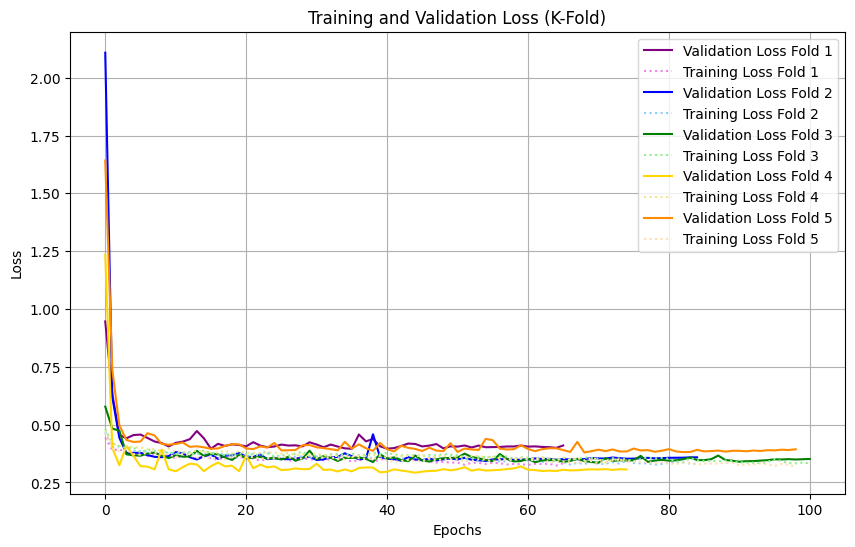

In [77]:
colors_val = ['purple', 'blue', 'green', 'gold', 'darkorange']
colors_train = ['violet', 'lightskyblue', 'lightgreen', 'khaki', 'navajowhite']

plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['val_loss'], color=colors_val[i], label=f'Validation Loss Fold {i+1}')
    plt.plot(history.history['loss'], color=colors_train[i], linestyle='dotted', label=f'Training Loss Fold {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (K-Fold)')
plt.legend()
plt.grid()
plt.show()

### **Submission**

In [78]:
# Results DataFrame
result_df = pd.DataFrame({
    ID: np.arange(2190, 2190 + len(final_predictions)),
    RAINFALL: final_predictions
})

print(result_df.head())

     id  rainfall
0  2190     1.000
1  2191     1.000
2  2192     1.000
3  2193     1.000
4  2194     1.000


In [79]:
result_df.to_csv('/'.join([path_output,'submission.csv']), index = False)
print(f"Submission saved as: submission.csv")

Submission saved as: submission.csv


In [80]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ (None, 64)             │        52,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,725 (807.52 KB)

 Trainable params: 50,977 (199.13 KB)

 Non-trainable params: 53,792 (210.12 KB)

 Optimizer params: 101,956 (398.27 KB)